In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/Help-Hinder_GNN_Project

/content/gdrive/My Drive/Help-Hinder_GNN_Project


# **PHASE Main Set**

## Load Model Predictions, Human Ratings, PHASE Labels

SIMPLE Predictions

In [129]:
dataset = "train" #this is what our phase main plot is using

if dataset == "train":
  f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_train_partial', 'r')
elif dataset == "train_new":
  f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_train_unrenderedunflipped', 'r')

entries = f.read().splitlines()
print("last episode no.", entries[-10]) #starts with episode 0
n = 399
print(entries[-1])


predictions = []

for e in range(1,n*6,6):
  v = dict()
  if dataset == "train":
    v['name'] = entries[e].split("/")[2][:24]
  elif dataset == "train_new":
    v['name'] = entries[e].split("/")[2][:23] #this and next line when using inference on train_new
    v['name'] = v['name'][:14] + '0' + v['name'][14:]

  v['inference'] = entries[e+2].split(" ")[2]
  v['gt'] = entries[e+4].split(" ")[2]
  predictions.append(v)

import pandas as pd
SIMPLE = pd.DataFrame(predictions)

#import numpy as np
#SIMPLE['correct'] = SIMPLE.apply(lambda x: 1 if x['inference']==x['gt'] else 0, axis = 1)
#print(np.mean(SIMPLE['correct']))
display(SIMPLE)

SIMPLE_dict = SIMPLE.set_index('name').T.to_dict('dict')

last episode no. episode_id: 398
relation accuracy: 0.7192982456140351


,name,inference,gt
0,D081820_13363300_0_F8_E0,friendly,friendly
1,D081820_16545200_0_F8_E2,adversarial,adversarial
2,D081920_01561200_0_F8_E6,adversarial,adversarial
3,D081920_03595900_0_F8_E7,adversarial,adversarial
4,D081920_08023200_0_F8_E6,friendly,friendly
...,...,...,...
394,D121320_07145900_0_F8_E2,adversarial,friendly
395,D121320_13405400_0_F8_E1,friendly,friendly
396,D121420_00140200_0_F8_E1,friendly,friendly
397,D121420_08260200_0_F8_E1,adversarial,friendly


Human Ratings: Labels and Agreement

In [130]:
import numpy as np
from collections import Counter
import pickle

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels', 'rb') as file:
    human_ratings_labels_dict = pickle.load(file)

HR_dict = {}
full_names = {}
for v,label in human_ratings_labels_dict.items():
  HR_dict[v[:24]] = label
  full_names[v[:24]] = v

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_agreement', 'rb') as file:
  HR_agreement_dict = pickle.load(file)

temp = {}
for k,v in HR_agreement_dict.items():
  temp[k[:24]] = v['relationship']

HR_agreement_dict = temp

## Combining our HR, PHASE HR, SIMPLE GT, PHASE GT, our pred, SIMPLE pred

In [138]:
def combine(pred_SocialGNN, pred_CueBasedLSTM, pred_CueBasedLSTM_R, SIMPLE_dict, HR_dict):
  names = []
  HR = []
  GT_SIMPLE = []
  Pred_SIMPLE = []
  Pred_SocialGNN = []
  Pred_CueBasedLSTM = []
  Pred_CueBasedLSTM_R = []
  for name, pred in pred_SocialGNN.items():
      try:
        GT_SIMPLE.append(SIMPLE_dict[name]['gt'])
        Pred_SIMPLE.append(SIMPLE_dict[name]['inference'])

        Pred_SocialGNN.append(pred_SocialGNN[name])
        Pred_CueBasedLSTM.append(pred_CueBasedLSTM[name])
        Pred_CueBasedLSTM_R.append(pred_CueBasedLSTM_R[name])

        HR.append(HR_dict[name]['relationship'])
        names.append(full_names[name])
      except:
        print("entry not found")

        GT_SIMPLE.append("NaN")
        Pred_SIMPLE.append("NaN")

        Pred_SocialGNN.append(pred_SocialGNN[name])
        Pred_CueBasedLSTM.append(pred_CueBasedLSTM[name])
        Pred_CueBasedLSTM_R.append(pred_CueBasedLSTM_R[name])

        HR.append(HR_dict[name]['relationship'])
        names.append(full_names[name])
   
  print("HR", Counter(HR))
  print("GT_SIMPLE", Counter(GT_SIMPLE))

  print("Pred SocialGNN", Counter(Pred_SocialGNN))
  print("Pred CueBasedLSTM", Counter(Pred_CueBasedLSTM))
  print("Pred CueBasedLSTM_R", Counter(Pred_CueBasedLSTM_R))
  print("Pred SIMPLE", Counter(Pred_SIMPLE))

  return names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR

def get_accuracy(a,b):
  mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2, 'NaN' : float("NaN")}
  #accuracy = np.mean(np.equal([mapping[x] for x in a], [mapping[x] for x in b]))
  n = min(sum(~np.isnan([mapping[x] for x in a])), sum(~np.isnan([mapping[x] for x in b])))
  accuracy = np.sum(np.equal([mapping[x] for x in a], [mapping[x] for x in b]))/n
  return accuracy

def load_combine_and_accuracy_onebootstrap(bootstrap_no, SIMPLE_dict, HR_dict, save_predictions_mode =False):
  with open('./Predictions/PHASE_mysplit_humanratings_May1_' + str(bootstrap_no) + '_SocialGNN_E', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_SocialGNN = {}
  for v,label in pred.items():
    pred_SocialGNN[v[:24]] = label


  with open('./Predictions/PHASE_mysplit_humanratings_May1_' + str(bootstrap_no) + '_CueBasedLSTM', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_CueBasedLSTM = {}
  for v,label in pred.items():
    pred_CueBasedLSTM[v[:24]] = label

  with open('./Predictions/PHASE_mysplit_humanratings_May1_' + str(bootstrap_no) + '_CueBasedLSTM-Relation', "rb") as f:
    true = pickle.load(f)
    pred = pickle.load(f)

  pred_CueBasedLSTM_R = {}
  for v,label in pred.items():
    pred_CueBasedLSTM_R[v[:24]] = label

  names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR = combine(pred_SocialGNN, pred_CueBasedLSTM, pred_CueBasedLSTM_R, SIMPLE_dict, HR_dict)

  print(get_accuracy(Pred_SocialGNN, HR))
  print(get_accuracy(Pred_CueBasedLSTM, HR))
  print(get_accuracy(Pred_CueBasedLSTM_R, HR))
  print(get_accuracy(Pred_SIMPLE, HR))
  print()
  print(get_accuracy(Pred_SocialGNN, GT_SIMPLE))
  print(get_accuracy(Pred_SIMPLE, GT_SIMPLE))

  if save_predictions_mode == True:
    return names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR

  return get_accuracy(Pred_SocialGNN, HR), get_accuracy(Pred_CueBasedLSTM, HR), get_accuracy(Pred_CueBasedLSTM_R, HR), get_accuracy(Pred_SIMPLE, HR)

  

## Accuracies Plot

In [139]:
accuracies = {'SocialGNN':[], 'CueBasedLSTM':[], 'CueBasedLSTM_R':[], 'SIMPLE':[]}
for bootstrap_no in range(10):
  print("\n\n")
  acc_SocialGNN, acc_CueBasedLSTM, acc_CueBasedLSTM_R, acc_SIMPLE = load_combine_and_accuracy_onebootstrap(bootstrap_no, SIMPLE_dict, HR_dict)
  accuracies['SocialGNN'].append(acc_SocialGNN)
  accuracies['CueBasedLSTM'].append(acc_CueBasedLSTM)
  accuracies['CueBasedLSTM_R'].append(acc_CueBasedLSTM_R)
  accuracies['SIMPLE'].append(acc_SIMPLE)




entry not found
HR Counter({'friendly': 40, 'adversarial': 36, 'neutral': 24})
GT_SIMPLE Counter({'friendly': 43, 'adversarial': 38, 'neutral': 18, 'NaN': 1})
Pred SocialGNN Counter({'friendly': 37, 'adversarial': 37, 'neutral': 26})
Pred CueBasedLSTM Counter({'adversarial': 42, 'friendly': 34, 'neutral': 24})
Pred CueBasedLSTM_R Counter({'friendly': 49, 'adversarial': 36, 'neutral': 15})
Pred SIMPLE Counter({'adversarial': 49, 'friendly': 35, 'neutral': 15, 'NaN': 1})
0.78
0.58
0.65
0.696969696969697

0.7272727272727273
0.7474747474747475



HR Counter({'adversarial': 43, 'friendly': 37, 'neutral': 20})
GT_SIMPLE Counter({'adversarial': 45, 'friendly': 37, 'neutral': 18})
Pred SocialGNN Counter({'adversarial': 46, 'friendly': 31, 'neutral': 23})
Pred CueBasedLSTM Counter({'adversarial': 45, 'friendly': 36, 'neutral': 19})
Pred CueBasedLSTM_R Counter({'adversarial': 46, 'friendly': 42, 'neutral': 12})
Pred SIMPLE Counter({'adversarial': 59, 'friendly': 25, 'neutral': 16})
0.72
0.57


In [140]:
!pip install statannotations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-141-73ddb200a0db>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: t-test paired samples with Holm-Bonferroni correction, P_val:6.469e-06 t=9.310e+00
VisualRNN-Rel vs. Inverse Planning: t-test paired samples with Holm-Bonferroni correction, P_val:8.044e-02 t=-1.969e+00
SocialGNN vs. VisualRNN-Rel: t-test paired samples with Holm-Bonferroni correction, P_val:2.484e-04 t=5.835e+00
VisualRNN vs. Inverse Planning: t-test paired samples with Holm-Bonferroni correction, P_val:4.062e-03 t=-3.824e+00
SocialGNN vs. Inverse Planning: t-test paired samples with Holm-Bonferroni correction, P_val:7.522e-05 t=6.844e+00


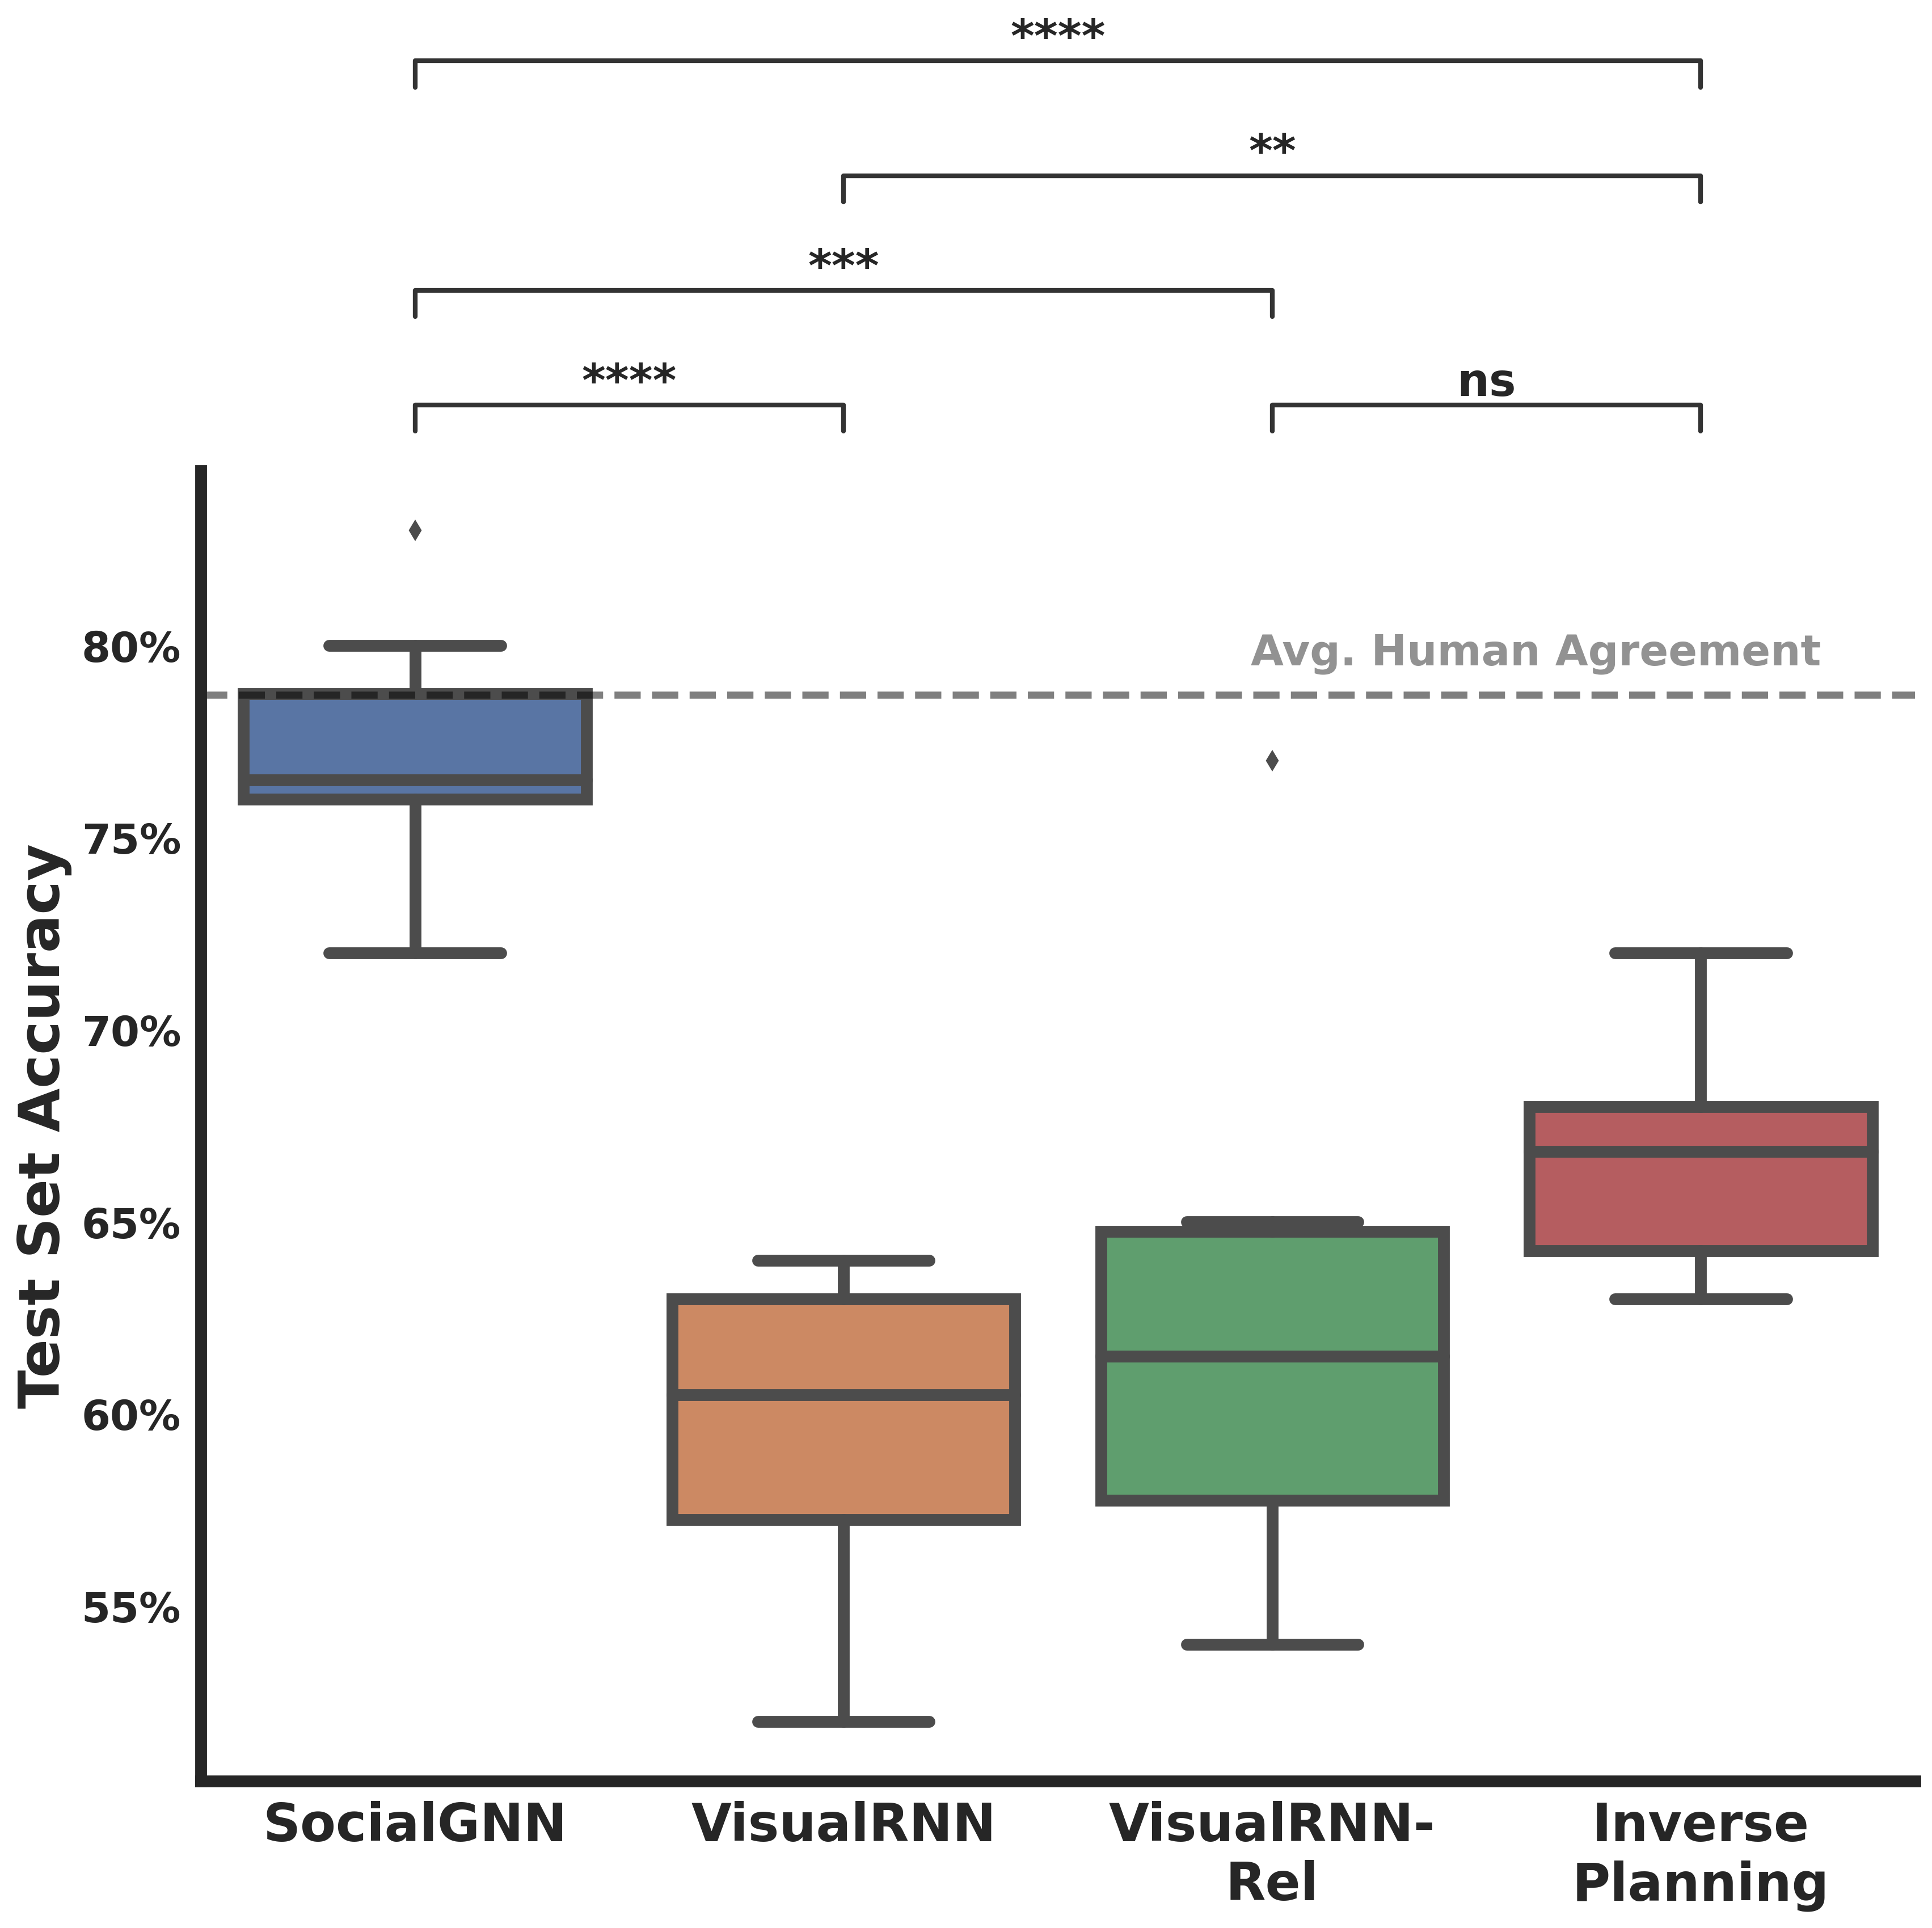

In [141]:
SocialGNN_E = {'testset': accuracies['SocialGNN']}
#SocialGNN_E= {'cross_val': [0.7766666666666667, 0.7833333333333333, 0.76, 0.7866666666666667, 0.7866666666666667, 0.7633333333333334, 0.78, 0.7733333333333332, 0.7566666666666667, 0.7533333333333333], 'entire_trainset': [0.9066666666666665, 0.9166666666666666, 0.9033333333333332, 0.91, 0.9233333333333332, 0.8866666666666666, 0.87, 0.8733333333333334, 0.91, 0.8566666666666667], 'testset': [0.78, 0.72, 0.8300000000000001, 0.76, 0.7699999999999999, 0.79, 0.76, 0.8, 0.72, 0.76]}

CueBasedLSTM_6 = {'testset': accuracies['CueBasedLSTM']}
#CueBasedLSTM_6 = {'cross_val': [0.5766666666666667, 0.5866666666666667, 0.5366666666666666, 0.6066666666666667, 0.5900000000000001, 0.5633333333333332, 0.5933333333333333, 0.5966666666666667, 0.5566666666666666, 0.5800000000000001], 'entire_trainset': [0.8000000000000002, 0.8533333333333332, 0.7666666666666665, 0.8433333333333335, 0.7900000000000003, 0.8499999999999999, 0.8399999999999999, 0.8566666666666666, 0.7633333333333333, 0.7433333333333334], 'testset': [0.58, 0.57, 0.62, 0.63, 0.5200000000000001, 0.63, 0.5900000000000001, 0.53, 0.64, 0.64]}

CueBasedLSTM_Relation_6 = {'testset': accuracies['CueBasedLSTM_R']}
#CueBasedLSTM_Relation_6 = {'cross_val': [0.63, 0.6766666666666665, 0.5966666666666667, 0.6133333333333333, 0.6466666666666666, 0.6166666666666666, 0.5666666666666667, 0.5866666666666667, 0.5966666666666667, 0.6066666666666667], 'entire_trainset': [0.8466666666666666, 0.8966666666666666, 0.8466666666666668, 0.8999999999999998, 0.8766666666666666, 0.8733333333333333, 0.7300000000000001, 0.8233333333333336, 0.81, 0.8799999999999998], 'testset': [0.65, 0.6500000000000001, 0.55, 0.7699999999999999, 0.6399999999999999, 0.6, 0.6199999999999999, 0.5700000000000001, 0.54, 0.61]}

SIMPLE = {'testset': accuracies['SIMPLE']}

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
df = pd.concat([pd.DataFrame(SocialGNN_E), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(SIMPLE)], keys=['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (13,10)

f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth=5)
#f.axhline(0.33, color = "black", ls = "--", alpha = 0.5)
f.axhline(0.7872, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(1.95, 0.795, "Avg. Human Agreement", fontsize=18, weight="bold", alpha = 0.5) #, bbox=dict(facecolor='red', alpha=0.5))

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel"), ('SocialGNN', 'Inverse Planning'),('Inverse Planning', 'VisualRNN'), ('Inverse Planning', 'VisualRNN-Rel') ]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
annotator.configure(comparisons_correction="HB", test='t-test_paired', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
annotator.apply_and_annotate()

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

from google.colab import files
plt.savefig("PHASE_wSIMPLE_trial.svg", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_wSIMPLE_trial.svg")

plt.show()

Permutation Testing instead of t-tests

<ipython-input-142-15ade510da6a>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
VisualRNN-Rel vs. Inverse Planning: Custom statistical test with Holm-Bonferroni correction, P_val:5.720e-02
SocialGNN vs. VisualRNN-Rel: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04
VisualRNN vs. Inverse Planning: Custom statistical test with Holm-Bonferroni correction, P_val:8.000e-04
SocialGNN vs. Inverse Planning: Custom statistical test with Holm-Bonferroni correction, P_val:2.000e-04


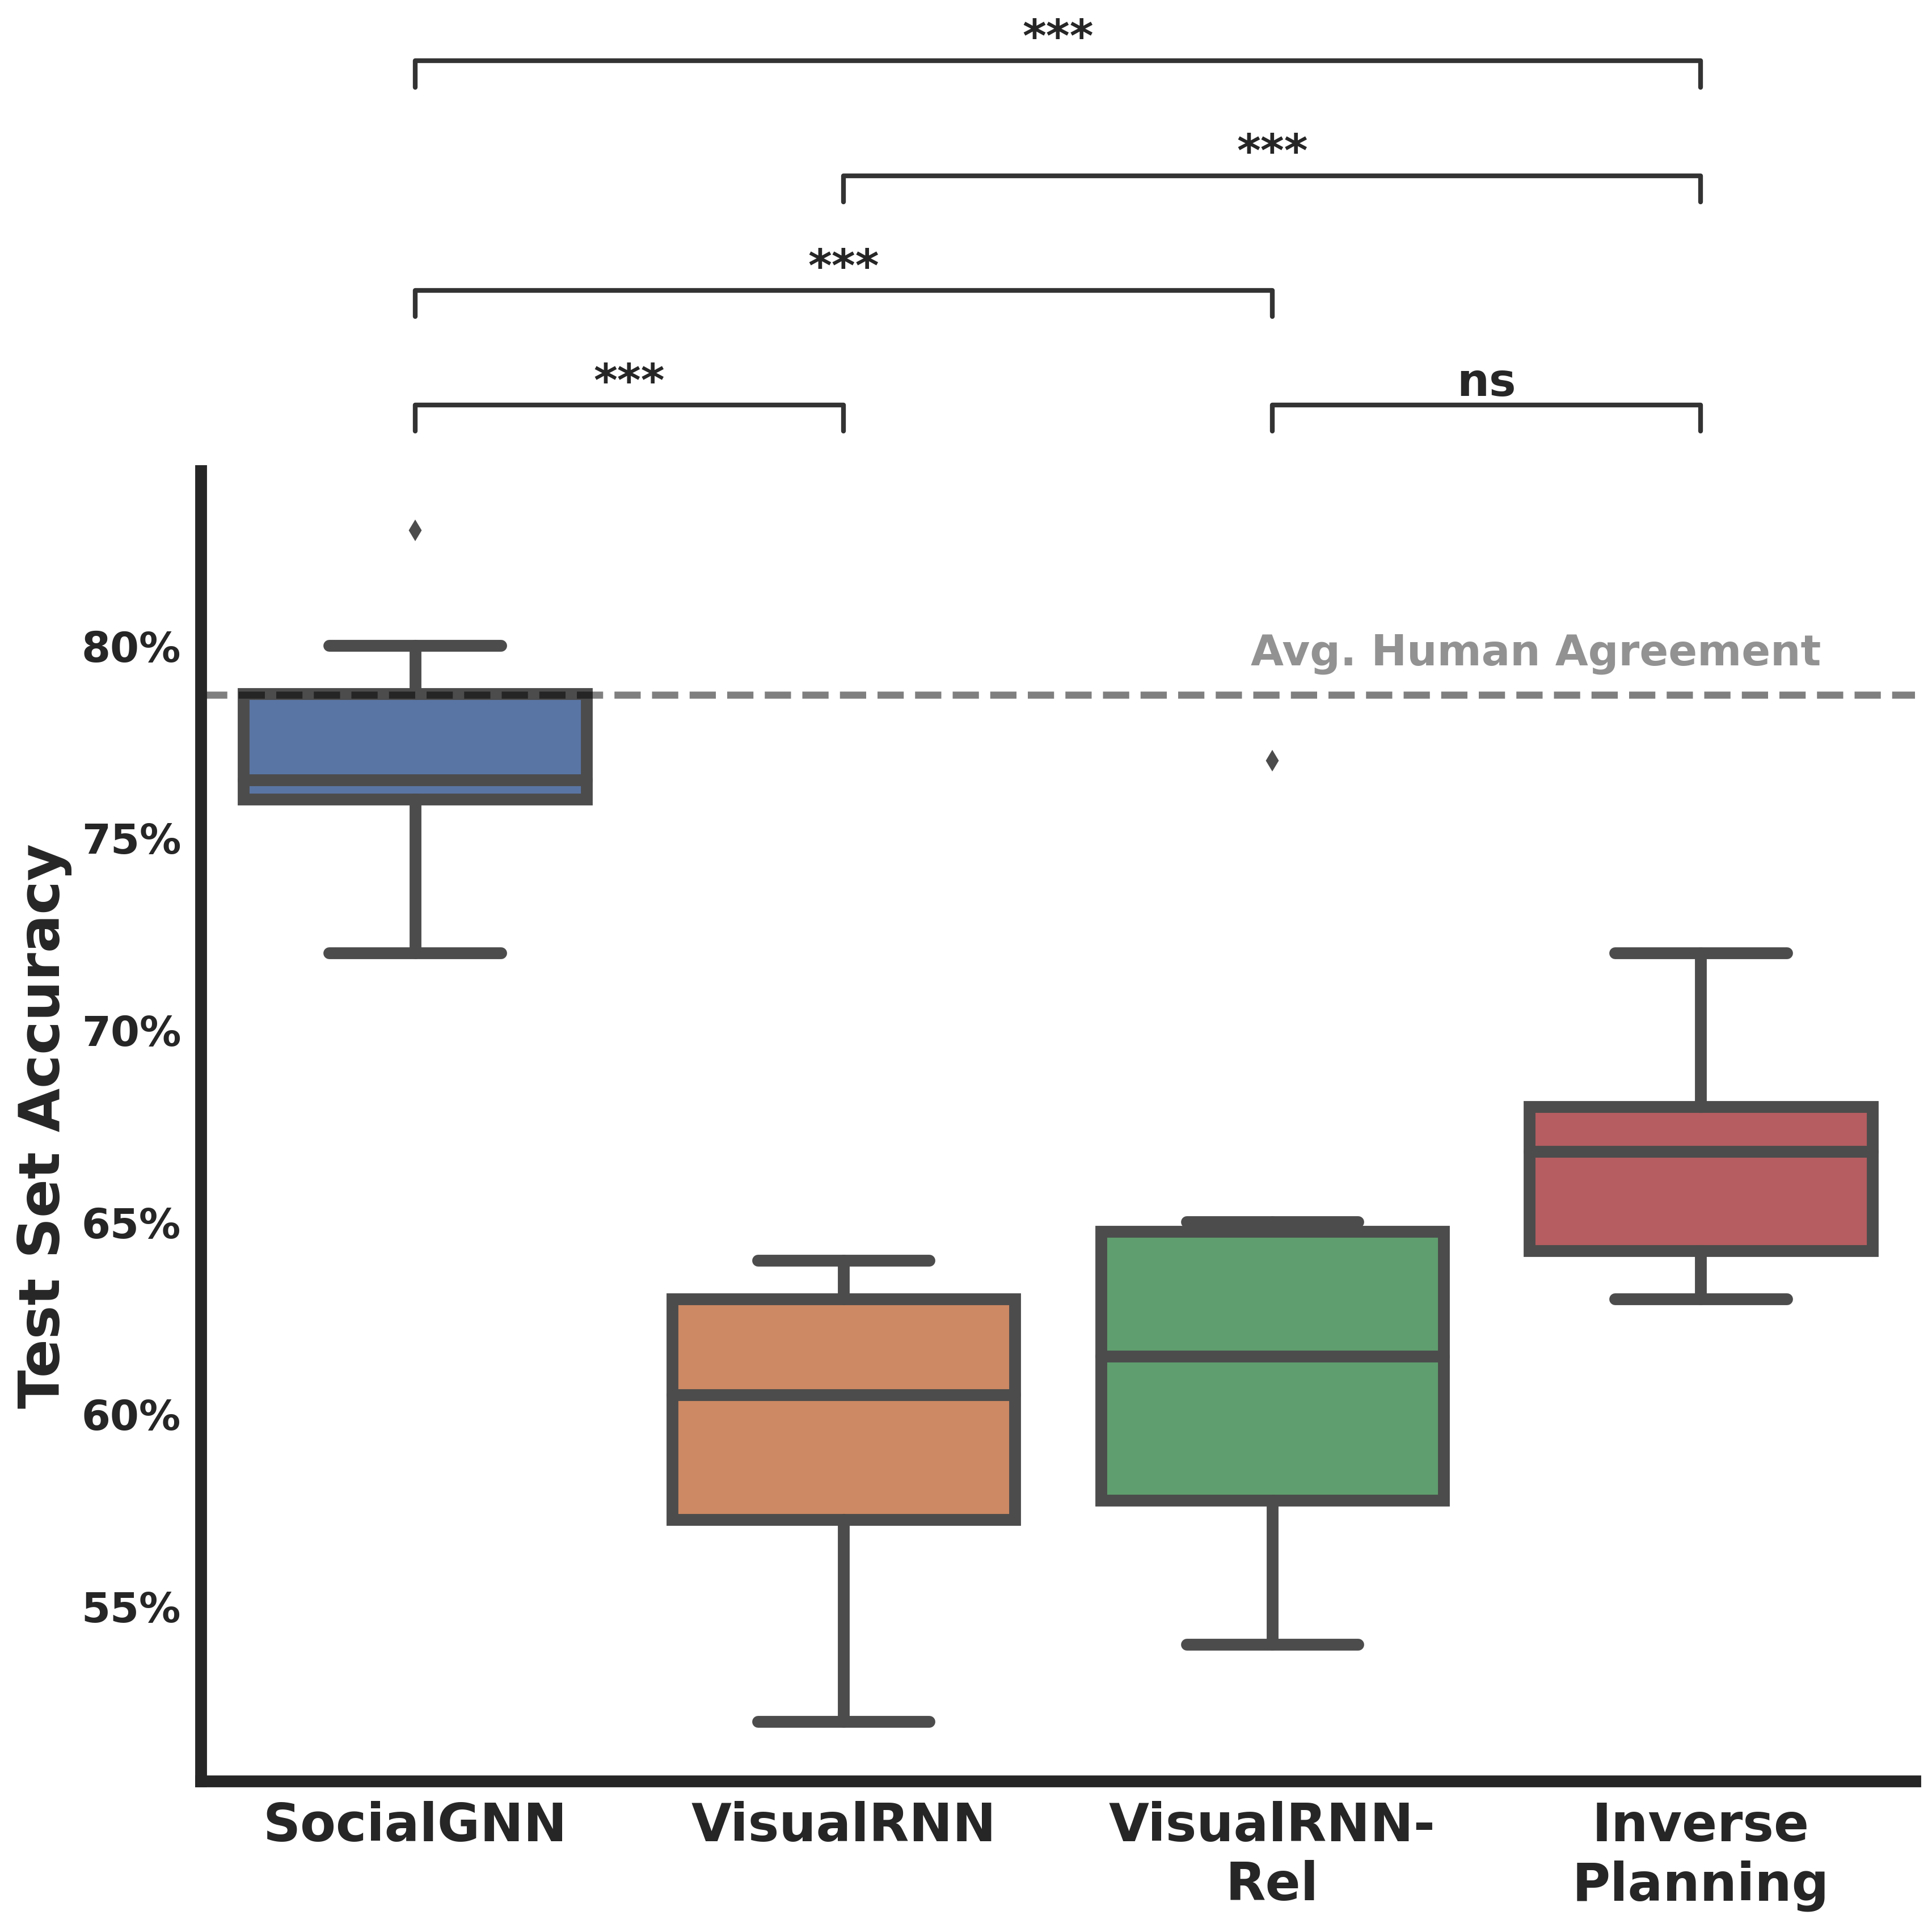

In [142]:
from statannotations.stats.StatTest import StatTest
from statannotations.Annotator import Annotator
from scipy.stats import permutation_test

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    
df = pd.concat([pd.DataFrame(SocialGNN_E), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(SIMPLE)], keys=['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (13,10)

f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth=5)
#f.axhline(0.33, color = "black", ls = "--", alpha = 0.5)
f.axhline(0.7872, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(1.95, 0.795, "Avg. Human Agreement", fontsize=18, weight="bold", alpha = 0.5) #, bbox=dict(facecolor='red', alpha=0.5))

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel', 'Inverse Planning']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel"), ('SocialGNN', 'Inverse Planning'),('Inverse Planning', 'VisualRNN'), ('Inverse Planning', 'VisualRNN-Rel') ]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
pvalues = []
for pair in pairs:
    data1 = df.groupby('model')['testset_accuracy'].get_group(pair[0])
    data2 = df.groupby('model')['testset_accuracy'].get_group(pair[1])
    res = permutation_test((data1, data2), statistic)
    pvalues.append(res.pvalue)
(annotator
 .configure(comparisons_correction="HB", test=None, test_short_name='permuation_test', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
 .set_pvalues(pvalues=pvalues)
 .annotate())

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

from google.colab import files
plt.savefig("PHASE_wSIMPLE_trial_permutationtest.svg", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_wSIMPLE_trial_permutationtest.svg")

plt.show()

## Accuracy as a function of Human agreement (one bootstrap) Plot

In [54]:
names, Pred_SocialGNN, Pred_CueBasedLSTM, Pred_CueBasedLSTM_R, Pred_SIMPLE, GT_SIMPLE, HR = load_combine_and_accuracy_onebootstrap(0, SIMPLE_dict, HR_dict, save_predictions_mode=True)

short_names = [x[:24] for x in names]

df = pd.DataFrame({"video_name": short_names, "SocialGNN":Pred_SocialGNN, "CueBasedLSTM":Pred_CueBasedLSTM, "SIMPLE":Pred_SIMPLE, "HR": HR})
df = df.set_index('video_name')

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_agreement', 'rb') as file:
  HR_agreement_dict = pickle.load(file)

temp = {}
for k,v in HR_agreement_dict.items():
  temp[k[:24]]=v['relationship'] #changed 23 to 24 on March 28th '23

HR_agreement = pd.DataFrame.from_dict(temp,orient='index',columns=['HR_agreement'])
print("\nEntire set avg HA", HR_agreement['HR_agreement'].mean())
print("This bootstrap avg HA", comb['HR_agreement'].mean())

all = pd.merge(df, HR_agreement, left_index=True, right_index=True)
all

entry not found
HR Counter({'friendly': 40, 'adversarial': 36, 'neutral': 24})
GT_SIMPLE Counter({'friendly': 43, 'adversarial': 38, 'neutral': 18, 'NaN': 1})
Pred SocialGNN Counter({'friendly': 37, 'adversarial': 37, 'neutral': 26})
Pred CueBasedLSTM Counter({'adversarial': 42, 'friendly': 34, 'neutral': 24})
Pred CueBasedLSTM_R Counter({'friendly': 49, 'adversarial': 36, 'neutral': 15})
Pred SIMPLE Counter({'adversarial': 49, 'friendly': 35, 'neutral': 15, 'NaN': 1})
0.78
0.58
0.65
0.696969696969697

0.7272727272727273
0.7474747474747475

Entire set avg HA 0.787197594072594
This bootstrap avg HA 0.8027960372960372


,SocialGNN,CueBasedLSTM,SIMPLE,HR,HR_agreement
D082520_02514200_0_F8_E0,neutral,adversarial,neutral,neutral,0.866667
D083020_06291500_0_F8_E8,friendly,friendly,adversarial,friendly,0.615385
D082120_00183400_0_F8_E1,friendly,friendly,friendly,friendly,0.846154
D121220_22361200_0_F8_E1,friendly,friendly,friendly,friendly,0.692308
D083020_19551800_0_F8_E1,neutral,neutral,neutral,neutral,1.000000
...,...,...,...,...,...
D121020_21594100_0_F8_E1,friendly,friendly,friendly,friendly,0.727273
D082720_19493400_0_F8_E1,adversarial,neutral,adversarial,neutral,0.818182
D082220_12152700_0_F8_E0,friendly,adversarial,friendly,friendly,1.000000
D081920_23380200_0_F8_E8,adversarial,adversarial,adversarial,adversarial,0.769231


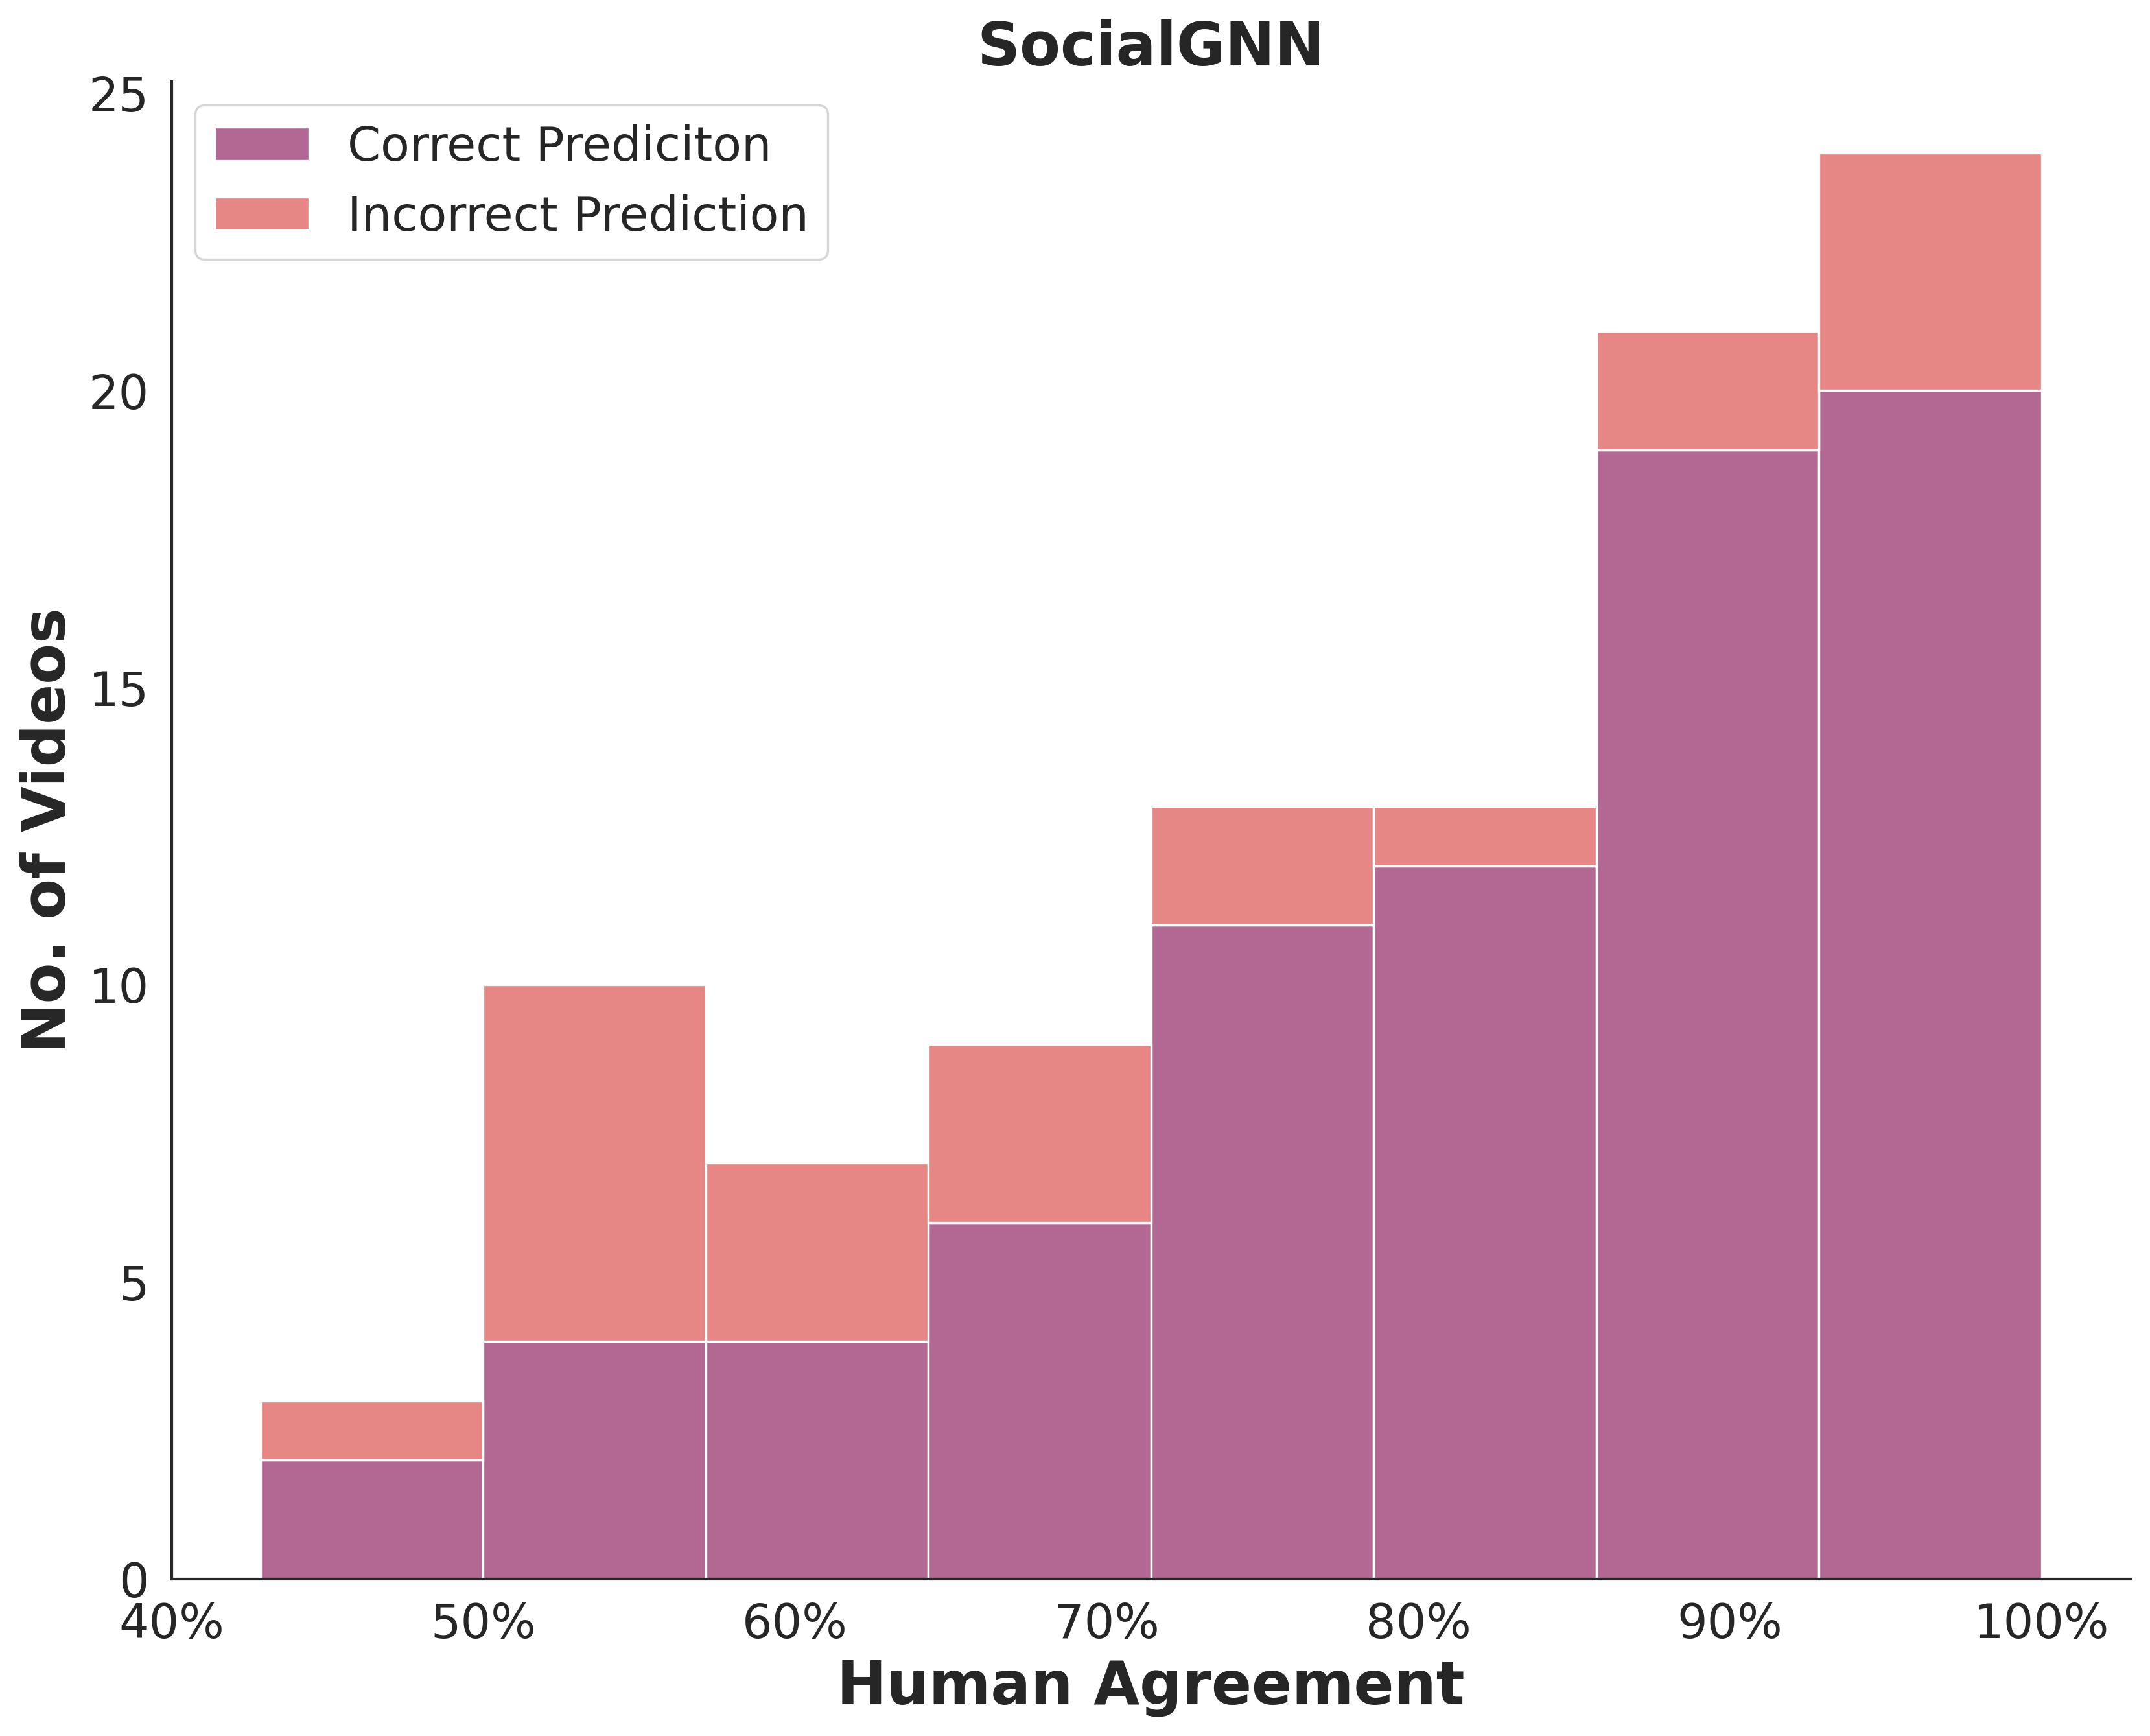

In [55]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")

acc_agr = all[['HR_agreement']].copy()
acc_agr['Correct'] = (all['SocialGNN'] == all['HR'])
#ax = acc_agr.pivot(columns='Correct').HR_agreement.plot(kind = 'hist', stacked=True, figsize=(10,7), bins=10)
temp = acc_agr.pivot(columns='Correct').HR_agreement
ax = sns.histplot(data=temp, multiple = "stack", palette = "flare")
ax.set_xlabel('Human Agreement', fontweight='bold', fontsize = 22)
ax.set_ylabel('No. of Videos', fontweight='bold', fontsize = 22)
ax.set_title('SocialGNN', fontweight='bold', fontsize = 22)

from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.legend(loc='upper left', labels=['Correct Prediciton', 'Incorrect Prediction'])
sns.despine()

from google.colab import files
import matplotlib.pyplot as plt
plt.savefig("acc_vs_humanagreement_bootstrap0_SocialGNN.svg", bbox_inches = 'tight', transparent = True)
#files.download("acc_vs_humanagreement_bootstrap0_SocialGNN.svg")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

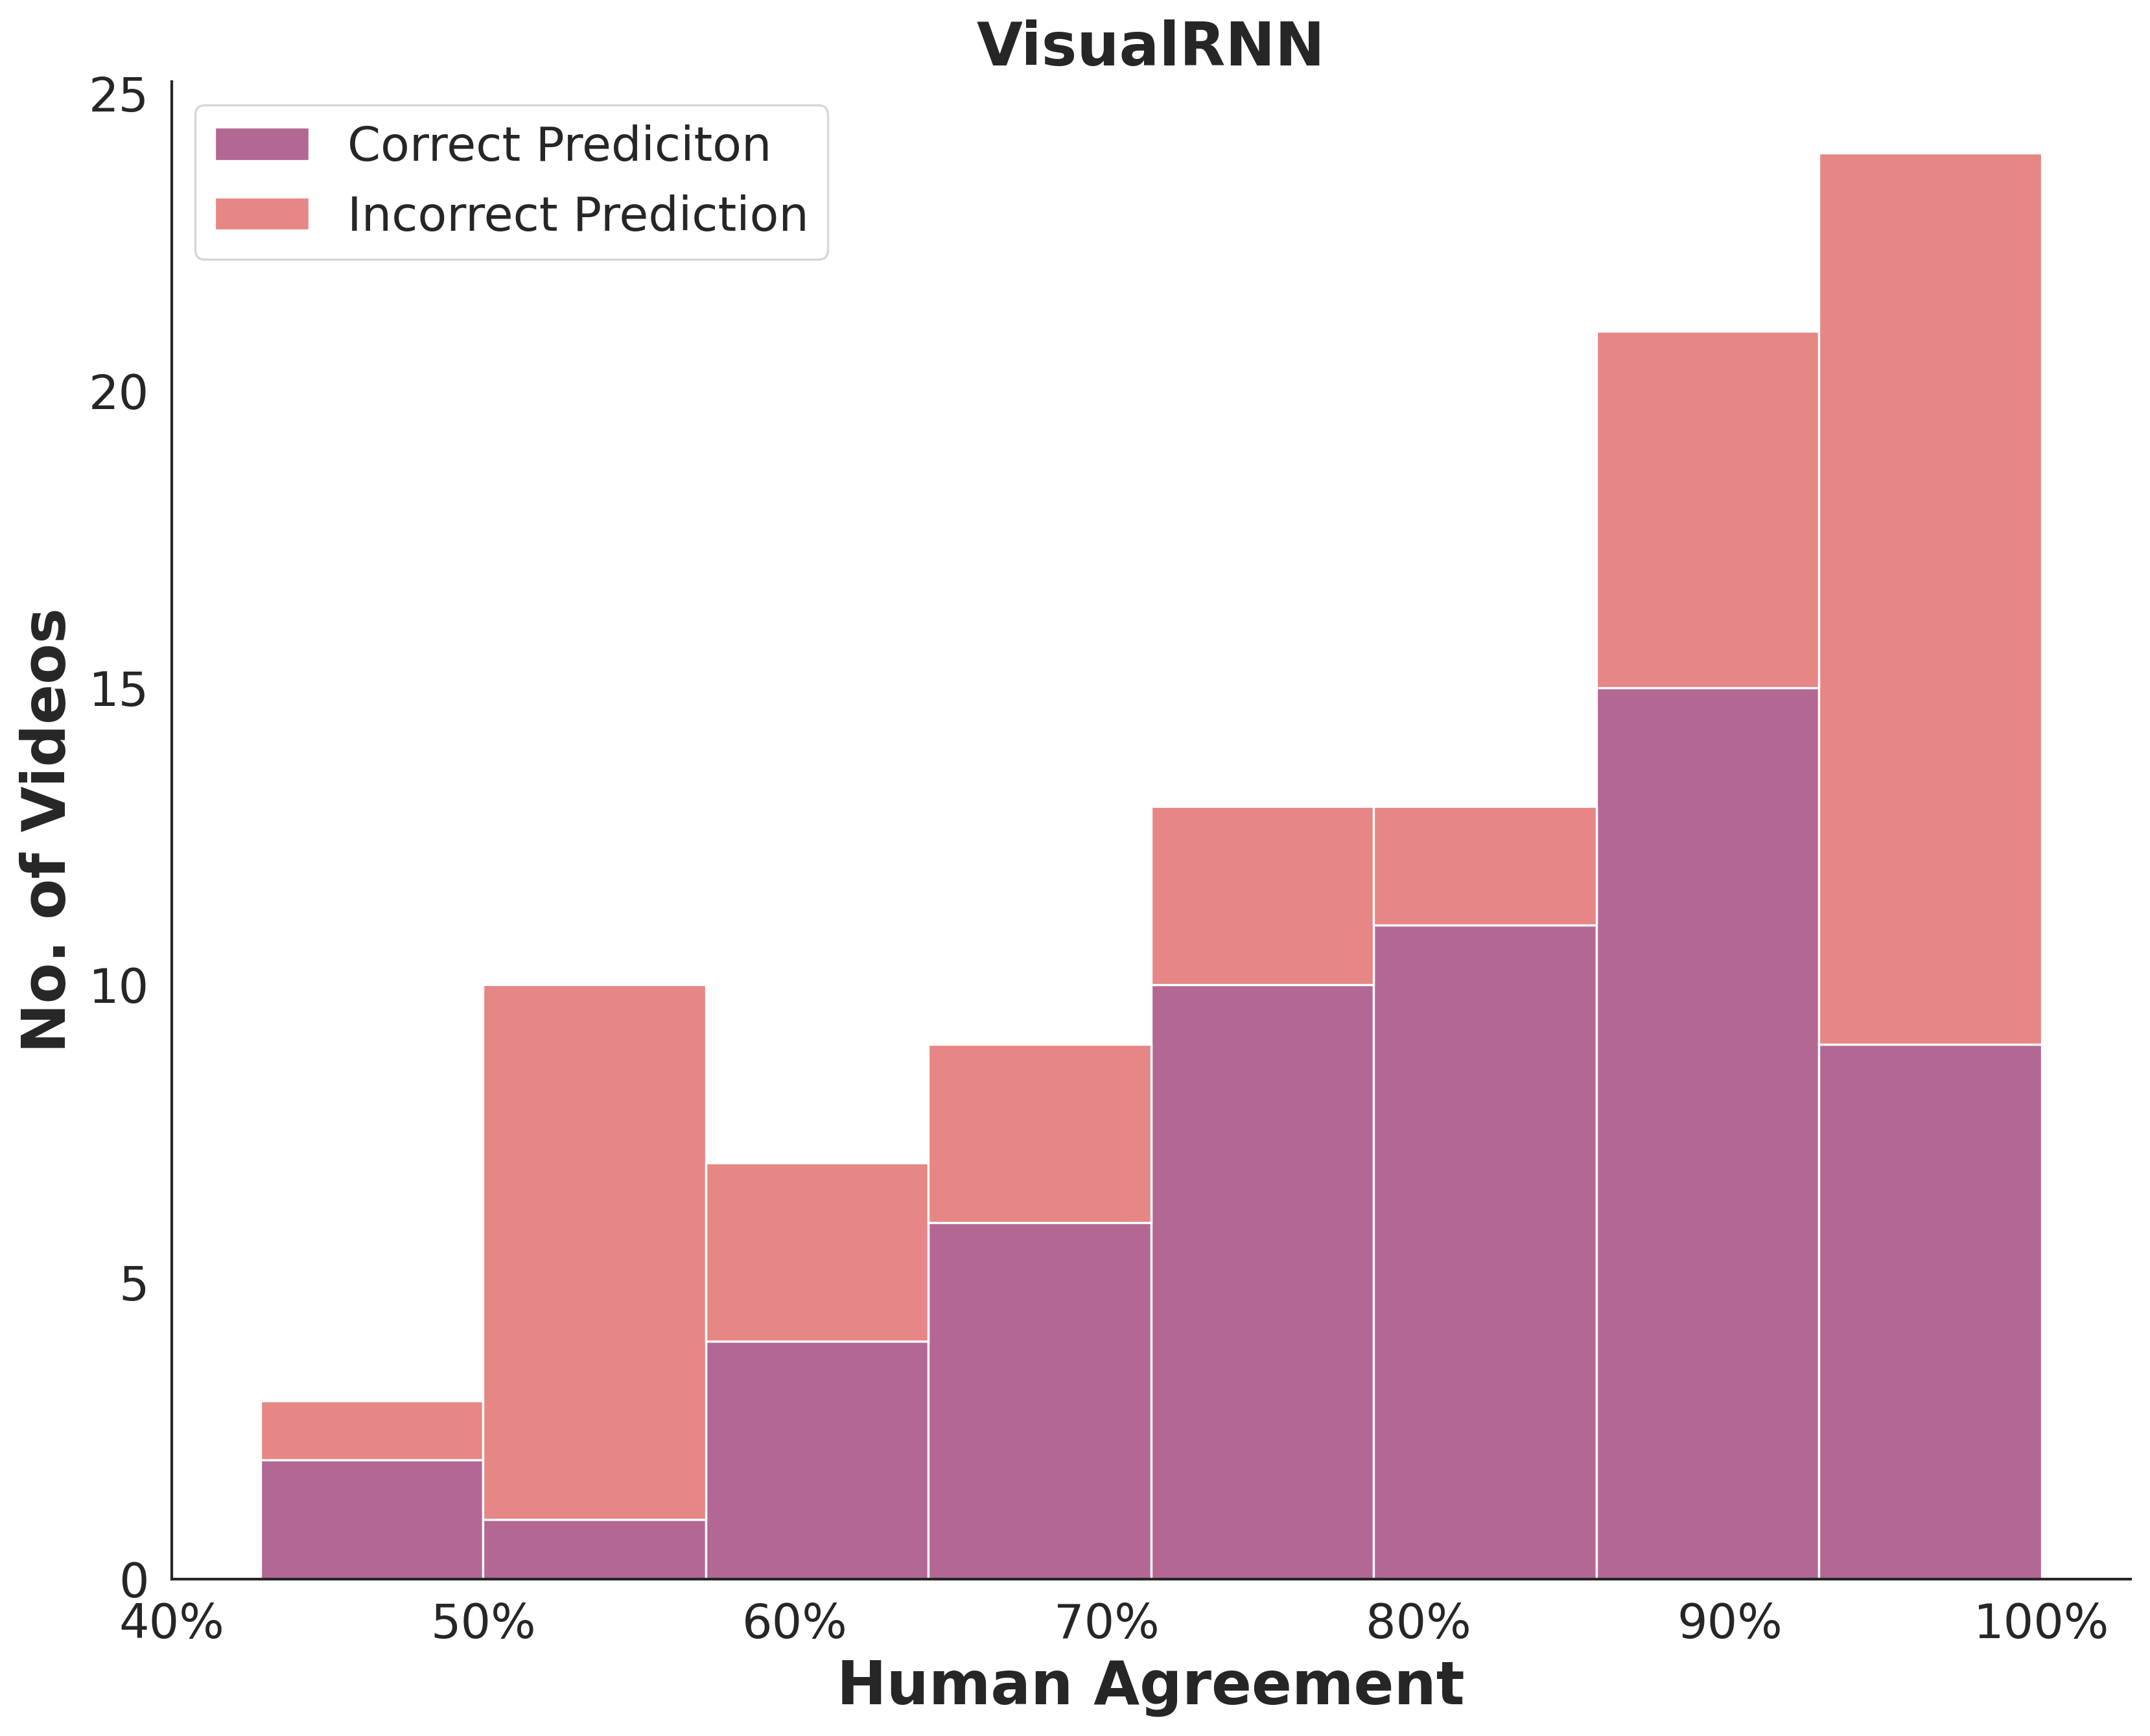

In [56]:
acc_agr = all[['HR_agreement']].copy()
acc_agr['Correct'] = (all['CueBasedLSTM'] == all['HR'])
temp = acc_agr.pivot(columns='Correct').HR_agreement
ax = sns.histplot(data=temp, multiple = "stack", palette = "flare")
ax.set_xlabel('Human Agreement', fontweight='bold', fontsize=22)
ax.set_ylabel('No. of Videos', fontweight='bold', fontsize=22)
ax.set_title('VisualRNN',  fontweight='bold', fontsize=22)

from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.legend(loc='upper left', labels=['Correct Prediciton', 'Incorrect Prediction'])
sns.despine()

import matplotlib.pyplot as plt
plt.savefig("acc_vs_humanagreement_bootstrap0_CueBasedLSTM.svg", bbox_inches = 'tight', transparent = True)
#files.download("acc_vs_humanagreement_bootstrap0_CueBasedLSTM.svg")

plt.show()

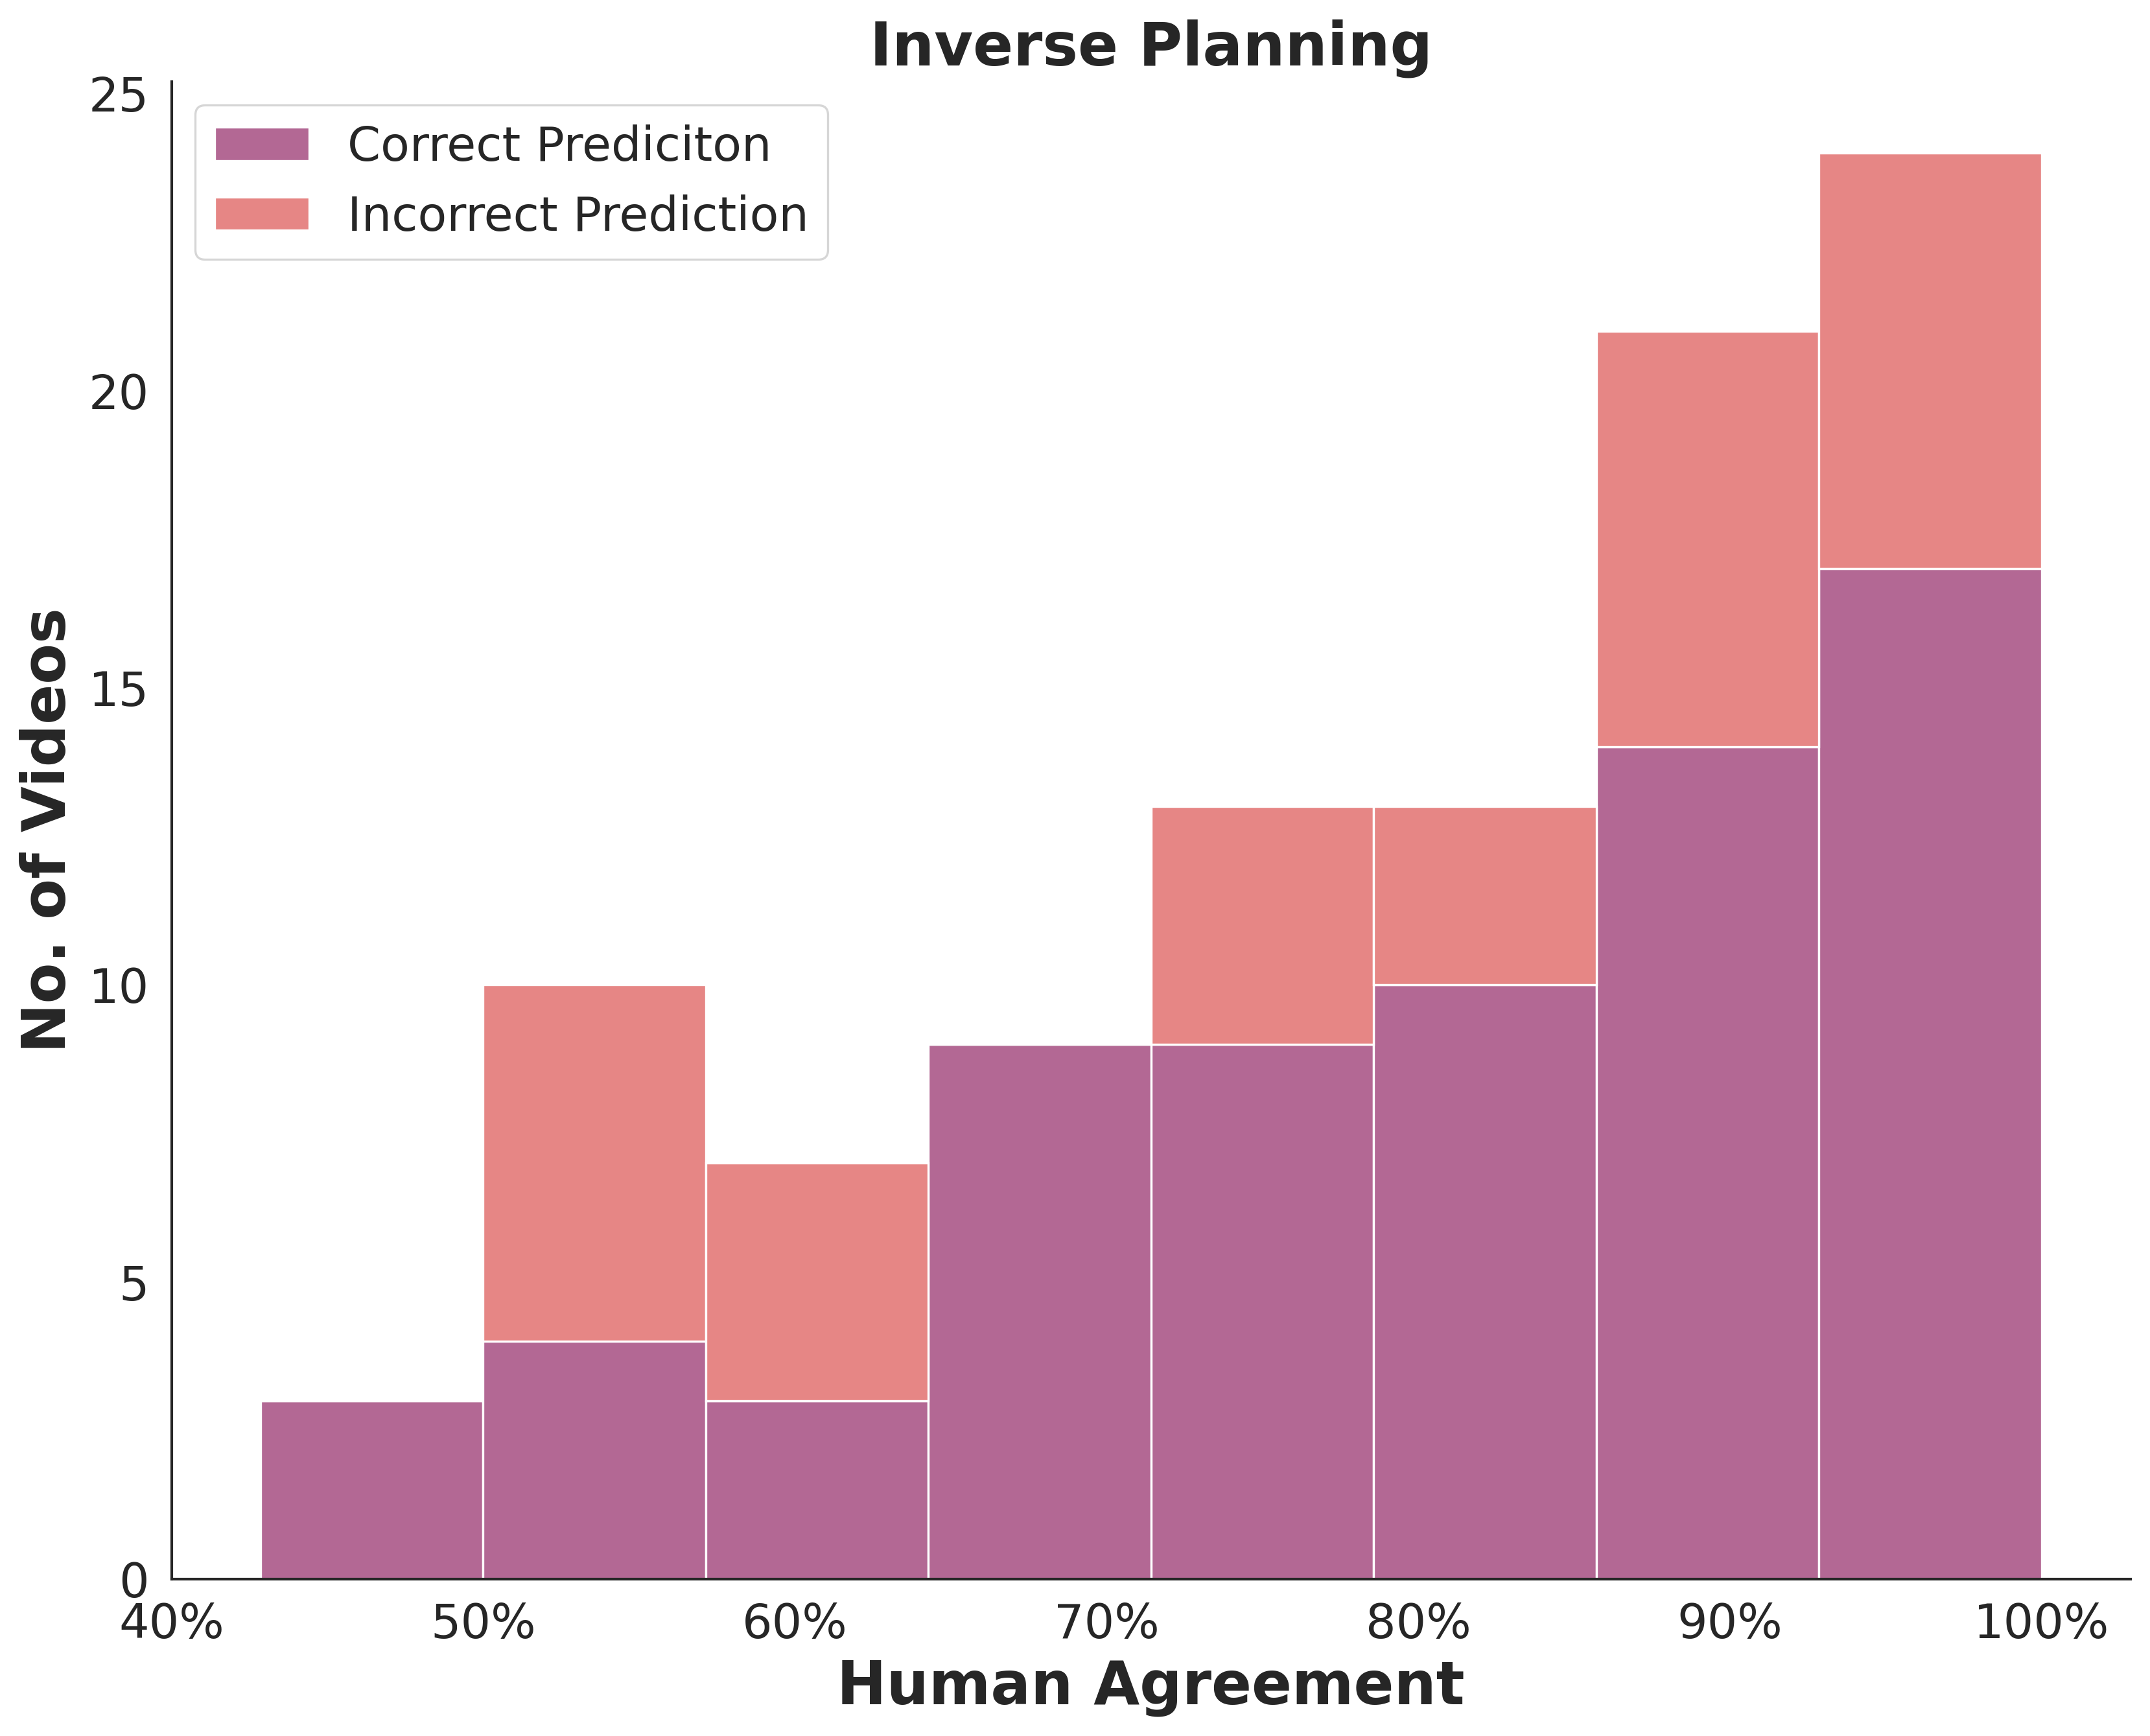

In [58]:
acc_agr = all[['HR_agreement']].copy()
acc_agr['Correct'] = (all['SIMPLE'] == all['HR'])
#ax = acc_agr.pivot(columns='Correct').HR_agreement.plot(kind = 'hist', stacked=True, figsize=(10,7), bins=10)
temp = acc_agr.pivot(columns='Correct').HR_agreement
ax = sns.histplot(data=temp, multiple = "stack", palette = "flare")
ax.set_xlabel('Human Agreement', fontweight='bold', fontsize=22)
ax.set_ylabel('No. of Videos', fontweight='bold', fontsize=22)
ax.set_title('Inverse Planning', fontweight='bold', fontsize=22)

from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.legend(loc='upper left', labels=['Correct Prediciton', 'Incorrect Prediction'])
sns.despine()

import matplotlib.pyplot as plt
plt.savefig("acc_vs_humanagreement_bootstrap0_SIMPLE.svg", bbox_inches = 'tight', transparent = True)
#files.download("acc_vs_humanagreement_bootstrap0_SIMPLE.svg")

plt.show()

## Ablation Study
(needs to be modified so it gets predictions + accuracies from files not hard coded)

In [63]:
SocialGNN_V = {'cross_val': [0.6799999999999999, 0.7466666666666667, 0.6900000000000001, 0.7333333333333334, 0.74, 0.7233333333333334, 0.7066666666666667, 0.7066666666666668, 0.74, 0.7166666666666666], 'entire_trainset': [0.9233333333333332, 0.9033333333333334, 0.92, 0.9133333333333332, 0.9199999999999999, 0.89, 0.9066666666666665, 0.9066666666666667, 0.9199999999999999, 0.8833333333333333], 'testset': [0.75, 0.6799999999999999, 0.8800000000000001, 0.74, 0.6699999999999999, 0.76, 0.6100000000000001, 0.76, 0.64, 0.76]}

SocialGNN_V_onlyagents = {'cross_val': [0.7, 0.6833333333333333, 0.6900000000000001, 0.6799999999999999, 0.7033333333333334, 0.6733333333333333, 0.71, 0.6733333333333333, 0.7066666666666666, 0.6866666666666666], 'entire_trainset': [0.8733333333333334, 0.8533333333333333, 0.8733333333333333, 0.8733333333333333, 0.8500000000000001, 0.8933333333333333, 0.8966666666666665, 0.8666666666666667, 0.9033333333333332, 0.8533333333333332], 'testset': [0.76, 0.75, 0.76, 0.74, 0.7, 0.68, 0.76, 0.64, 0.6199999999999999, 0.76]}

SocialGNN_E= {'cross_val': [0.7766666666666667, 0.7833333333333333, 0.76, 0.7866666666666667, 0.7866666666666667, 0.7633333333333334, 0.78, 0.7733333333333332, 0.7566666666666667, 0.7533333333333333], 'entire_trainset': [0.9066666666666665, 0.9166666666666666, 0.9033333333333332, 0.91, 0.9233333333333332, 0.8866666666666666, 0.87, 0.8733333333333334, 0.91, 0.8566666666666667], 'testset': [0.78, 0.72, 0.8300000000000001, 0.76, 0.7699999999999999, 0.79, 0.76, 0.8, 0.72, 0.76]}

SocialGNN_E_onlyagentedges = {'cross_val': [0.49000000000000005, 0.4966666666666667, 0.4766666666666667, 0.49000000000000005, 0.53, 0.5566666666666666, 0.5166666666666667, 0.49333333333333335, 0.54, 0.5466666666666666], 'entire_trainset': [0.5266666666666666, 0.56, 0.5733333333333334, 0.5466666666666667, 0.5766666666666667, 0.6066666666666668, 0.58, 0.5399999999999999, 0.5833333333333334, 0.5733333333333335], 'testset': [0.51, 0.53, 0.6, 0.54, 0.54, 0.4800000000000001, 0.55, 0.5800000000000001, 0.42000000000000004, 0.53]}

CueBasedLSTM_20 = {'cross_val': [0.5999999999999999, 0.6599999999999999, 0.5766666666666667, 0.6366666666666667, 0.6399999999999999, 0.6366666666666666, 0.5966666666666667, 0.65, 0.6566666666666667, 0.6433333333333333], 'entire_trainset': [0.8833333333333333, 0.9499999999999998, 0.8566666666666666, 0.9166666666666665, 0.9166666666666667, 0.9266666666666666, 0.9199999999999999, 0.95, 0.9299999999999999, 0.9233333333333333], 'testset': [0.6599999999999999, 0.67, 0.63, 0.63, 0.59, 0.5900000000000001, 0.59, 0.6500000000000001, 0.6599999999999999, 0.67]}

CueBasedLSTM_12 = {'cross_val': [0.6166666666666666, 0.6399999999999999, 0.6066666666666667, 0.59, 0.5966666666666667, 0.6599999999999999, 0.6466666666666667, 0.6266666666666667, 0.6366666666666666, 0.6066666666666667], 'entire_trainset': [0.8966666666666666, 0.9066666666666665, 0.8699999999999999, 0.9066666666666665, 0.9033333333333332, 0.9133333333333332, 0.92, 0.9099999999999999, 0.9266666666666665, 0.8766666666666666], 'testset': [0.6000000000000001, 0.5900000000000001, 0.65, 0.65, 0.5599999999999999, 0.57, 0.6, 0.6199999999999999, 0.61, 0.6799999999999999]}

CueBasedLSTM_6 = {'cross_val': [0.5766666666666667, 0.5866666666666667, 0.5366666666666666, 0.6066666666666667, 0.5900000000000001, 0.5633333333333332, 0.5933333333333333, 0.5966666666666667, 0.5566666666666666, 0.5800000000000001], 'entire_trainset': [0.8000000000000002, 0.8533333333333332, 0.7666666666666665, 0.8433333333333335, 0.7900000000000003, 0.8499999999999999, 0.8399999999999999, 0.8566666666666666, 0.7633333333333333, 0.7433333333333334], 'testset': [0.58, 0.57, 0.62, 0.63, 0.5200000000000001, 0.63, 0.5900000000000001, 0.53, 0.64, 0.64]}

#CueBasedLSTM_6 = {'cross_val': [0.58, 0.6033333333333334, 0.55, 0.57, 0.6133333333333333, 0.6333333333333333, 0.5799999999999998, 0.5833333333333333, 0.6066666666666667, 0.5900000000000001], 'entire_trainset': [0.7533333333333334, 0.8100000000000002, 0.8699999999999998, 0.8499999999999999, 0.8533333333333332, 0.8533333333333335, 0.85, 0.8666666666666667, 0.8166666666666667, 0.8599999999999998], 'testset': [0.58, 0.56, 0.7300000000000001, 0.63, 0.6, 0.65, 0.53, 0.5700000000000001, 0.55, 0.6100000000000001]}

CueBasedLSTM_Relation_6 = {'cross_val': [0.63, 0.6766666666666665, 0.5966666666666667, 0.6133333333333333, 0.6466666666666666, 0.6166666666666666, 0.5666666666666667, 0.5866666666666667, 0.5966666666666667, 0.6066666666666667], 'entire_trainset': [0.8466666666666666, 0.8966666666666666, 0.8466666666666668, 0.8999999999999998, 0.8766666666666666, 0.8733333333333333, 0.7300000000000001, 0.8233333333333336, 0.81, 0.8799999999999998], 'testset': [0.65, 0.6500000000000001, 0.55, 0.7699999999999999, 0.6399999999999999, 0.6, 0.6199999999999999, 0.5700000000000001, 0.54, 0.61]}


In [ ]:
!pip install statannotations

<ipython-input-67-9a0bb760d7f0>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN_V vs. SocialGNN_E: t-test paired samples with Holm-Bonferroni correction, P_val:3.277e-02 (ns) t=-2.520e+00
SocialGNN_E vs. VisualRNN: t-test paired samples with Holm-Bonferroni correction, P_val:6.469e-06 t=9.310e+00
VisualRNN vs. VisualRNN-Rel: t-test paired samples with Holm-Bonferroni correction, P_val:3.514e-01 t=-9.827e-01
VisualRNN-Rel vs. SocialGNN_V_onlyagents: t-test paired samples with Holm-Bonferroni correction, P_val:9.435e-04 t=-4.823e+00
SocialGNN_V_onlyagents vs. SocialGNN_E_onlyagentedges: t-test paired samples with Holm-Bonferroni correction, P_val:1.351e-06 t=1.123e+01
SocialGNN_E_onlyagentedges vs. SIMPLE: t-test paired samples with Holm-Bonferroni correction, P_val:5.602e-05 t=-7.111e+00
SocialGNN_V vs. VisualRNN: t-test paired samples with Holm-Bonferroni correction, P_val:6.5

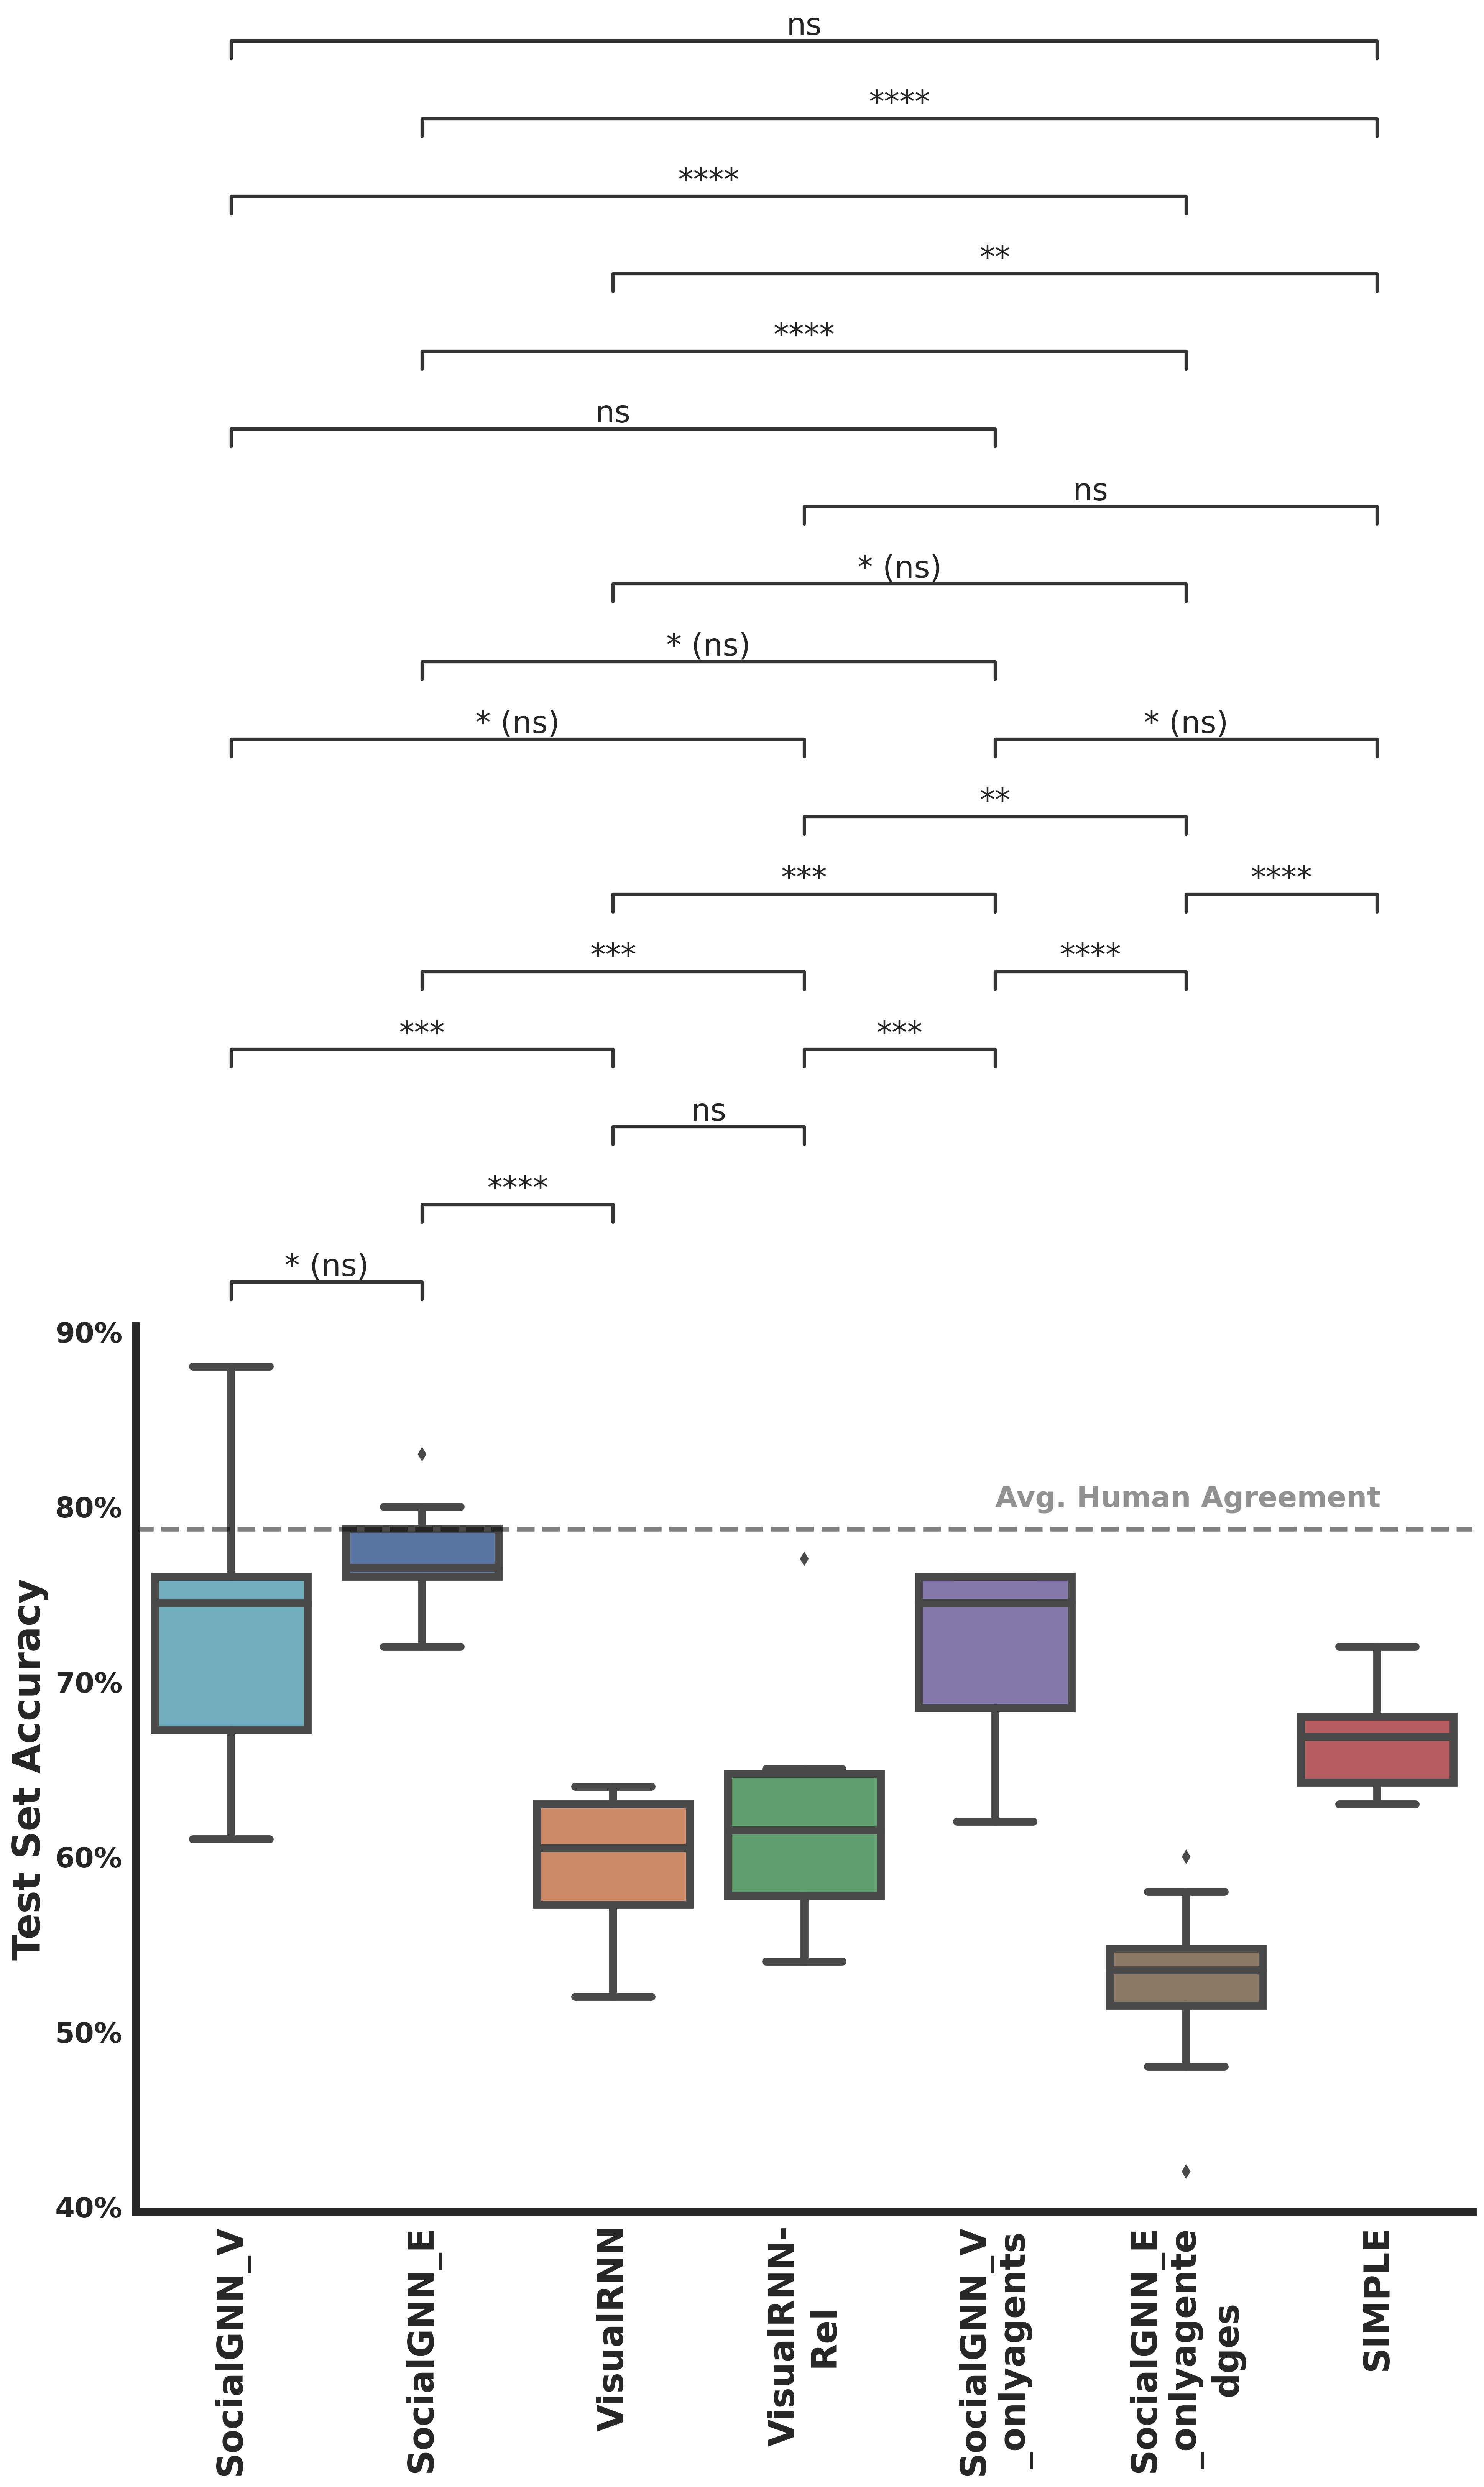

In [67]:
from statannotations.Annotator import Annotator

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(SocialGNN_E), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6), pd.DataFrame(SocialGNN_V_onlyagents), pd.DataFrame(SocialGNN_E_onlyagentedges), pd.DataFrame(SIMPLE)], keys=['SocialGNN_V', 'SocialGNN_E', 'VisualRNN', 'VisualRNN-Rel', 'SocialGNN_V_onlyagents', 'SocialGNN_E_onlyagentedges', 'SIMPLE']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (15,10)

p = [(0.39215686274509803, 0.7098039215686275, 0.803921568627451), (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),  (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137)]
f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth=5, palette = p)
#f.axhline(0.33, color = "black", ls = "--", alpha = 0.5)
f.axhline(0.7872, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(4, 0.8, "Avg. Human Agreement", fontsize=18, weight="bold", alpha = 0.5) #, bbox=dict(facecolor='red', alpha=0.5))

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 90, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)


# Significance testing
from itertools import combinations
order = ['SocialGNN_V', 'SocialGNN_E', 'VisualRNN', 'VisualRNN-Rel', 'SocialGNN_V_onlyagents', 'SocialGNN_E_onlyagentedges', 'SIMPLE']
pairs = list(combinations(order, 2))
#pairs=[("SocialGNN_V", "VisualRNN"), ("SocialGNN_E", "VisualRNN"), ('VisualRNN-Rel', 'SocialGNN_E'), ('SocialGNN_V', 'SocialGNN_V_onlyagents'), ('SocialGNN_E', 'SIMPLE')]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
annotator.configure(comparisons_correction="HB", test='t-test_paired', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
annotator.apply_and_annotate()

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

from google.colab import files
plt.savefig("PHASE_ablationmodels.svg", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_ablationmodels.svg")

plt.show()

# **PHASE Generalization Set**

## Load Model Predictions, Human Ratings, PHASE Labels

SIMPLE, SocialGNN and VisualRNN Predictions

In [101]:
f = open('./SIMPLE-new-main/SIMPLE_predicted_labels_test', 'r')
entries = f.read().splitlines()

predictions = []

for e in range(1,600,6):
  v = dict()
  v['name'] = entries[e].split("/")[2][:23]
  v['inference'] = entries[e+2].split(" ")[2]
  v['gt'] = entries[e+4].split(" ")[2]
  predictions.append(v)

import pandas as pd
SIMPLE = pd.DataFrame(predictions)

#SIMPLE['correct'] = SIMPLE.apply(lambda x: 1 if x['inference']==x['gt'] else 0, axis = 1)
#print(sum(SIMPLE['correct']))
display(SIMPLE)

SIMPLE_dict = SIMPLE.set_index('name').T.to_dict('dict')


import pickle
with open('./Predictions/PHASE_originalsplit_withcontext_June28_SocialGNN_E', "rb") as f:
  true = pickle.load(f)
  pred = pickle.load(f)

pred_SocialGNN = {}
for v,label in pred.items():
  pred_SocialGNN[v[:23]] = label


with open('./Predictions/PHASE_originalsplit_withcontext_June28_CueBasedLSTM', "rb") as f:
  true = pickle.load(f)
  pred = pickle.load(f)

pred_CueBasedLSTM = {}
for v,label in pred.items():
  pred_CueBasedLSTM[v[:23]] = label

len(pred_SocialGNN), len(pred_CueBasedLSTM)

,name,inference,gt
0,D081920_0035030_0_F8_E8,friendly,friendly
1,D081920_1135270_0_F8_E1,friendly,friendly
2,D082020_1817530_0_F8_E8,friendly,friendly
3,D082120_0315260_0_F8_E1,friendly,friendly
4,D082120_1315000_0_F8_E7,neutral,adversarial
...,...,...,...
95,D083120_1954500_0_F8_E1,friendly,friendly
96,D090120_1849520_0_F8_E4,adversarial,adversarial
97,D090220_0310200_0_F8_E1,adversarial,adversarial
98,D090220_1953260_0_F8_E9,adversarial,adversarial


100

Human Ratings: Labels and Agreement

In [87]:
with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_agreement_test', 'rb') as file:
  HR_agreement_dict = pickle.load(file)

temp = {}
for k,v in HR_agreement_dict.items():
  temp[k[:24]] = v['relationship']

HR_agreement_dict = temp

with open('./SocialGNN_Final/Human_Experiment_Files/human_rating_labels_test', 'rb') as file:
    human_ratings_labels_dict = pickle.load(file)


PHASE labels (social goals used to generate videos) + PHASE HR

In [88]:
import os
path = './SocialGNN_Final/PHASE/test'
n_videos = len(os.listdir(path))


import json
from collections import Counter
import pandas as pd
from scipy import stats

f = open("./individual_ans.json", "rb")

data = json.load(f)
print("Number of subjects: ",len(data))

data_filtered = {'videos':[], 'relationship':[]}

realness_rating = {'videos':[], 'realness':[]}

for participant in data:
  for row in participant:
    if 'question' in row.keys() and row['question']=='What is the relationship?':
      data_filtered['videos'].append(row['name'])
      data_filtered['relationship'].append(row['value'])
    if 'question' in row.keys() and row['question']=='Would a human do the same?':
      realness_rating['videos'].append(row['name'])
      realness_rating['realness'].append(row['value'])

data = pd.DataFrame(data_filtered)
HR_PHASE = data.groupby(by='videos').agg(lambda x: stats.mode(x)[0][0])
HR_PHASE.index = HR_PHASE.index.str[:51]
HR_PHASE_dict = HR_PHASE.to_dict('index')
HR_PHASE

Number of subjects:  100


<ipython-input-88-30073f9ceb0a>:30: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  HR_PHASE = data.groupby(by='videos').agg(lambda x: stats.mode(x)[0][0])


,relationship
videos,
"D081920_0035030_G['LMO', 0, 3, 1]_['LMO', 0, 3, 1]_",Friendly
"D081920_1135270_G['LMO', 0, 3, 1]_['LMO', 0, 3, 1]_",Friendly
"D082020_1817530_G['LMO', 0, 0, 1]_['LMO', 0, 0, 1]_",Friendly
"D082120_0315260_G['LMO', 1, 1, 1]_['LMO', 1, 1, 1]_",Friendly
"D082120_1315000_G['LMA', 0, 0, 1]_['LMA', 0, 0, -1]",Adversarial
...,...
"D083120_1954500_G['LMO', 0, 1, 1]_['LMO', 0, 1, 1]_",Friendly
"D090120_1849520_G['LMO', 1, 0, 1]_['LMO', 1, 1, 1]_",Adversarial
"D090220_0310200_G['LMO', 1, 0, 1]_['LMO', 1, 2, 1]_",Adversarial


## Combining our HR, PHASE HR, SIMPLE GT, PHASE GT, our pred, VisualRRN pred, SIMPLE pred

In [103]:
import numpy as np

names = []
GT = []
HR = []
HR_PHASE = []
GT_SIMPLE = []
Pred_SIMPLE = []
Pred_SocialGNN = []
Pred_CueBasedLSTM = []

mapping = {'Friendly':'friendly', "Neutral":'neutral', 'Adversarial':'adversarial'}
for root, dirs, files, in os.walk(path):
  for file in files:
    if file.endswith(".pik"):
      open_f = open(path + '/' + file, 'rb')
      open_f_data = pickle.load(open_f)
      v = {}
      v['name'] = file[:-3] + 'mp4'
      names.append(v['name'])

      GT.append(open_f_data['modes'][0][0])
      HR.append(human_ratings_labels_dict[v['name']]['relationship'])

      ind = file.find('G')
      f_name = file[:15]+ file[ind-1:ind+35]
      HR_PHASE.append(mapping[HR_PHASE_dict[f_name]['relationship']])

      GT_SIMPLE.append(SIMPLE_dict[file[:23]]['gt'])

      Pred_SIMPLE.append(SIMPLE_dict[file[:23]]['inference'])
      Pred_SocialGNN.append(pred_SocialGNN[file[:23]])
      Pred_CueBasedLSTM.append(pred_CueBasedLSTM[file[:23]])
      

print("GT", Counter(GT))
print("HR", Counter(HR))
print("HR_PHASE", Counter(HR_PHASE))
print("GT_SIMPLE", Counter(GT_SIMPLE))

print("Pred SIMPLE", Counter(Pred_SIMPLE))
print("Pred SocialGNN", Counter(Pred_SocialGNN))
print("Pred VisualRNN", Counter(Pred_CueBasedLSTM))

# Note: possibly stats.mode changed slightly, so we see a small difference here in HR_PHASE distribution as compared to when this was run earlier

GT Counter({'neutral': 62, 'friendly': 21, 'adversarial': 17})
HR Counter({'friendly': 37, 'adversarial': 36, 'neutral': 27})
HR_PHASE Counter({'adversarial': 37, 'friendly': 37, 'neutral': 26})
GT_SIMPLE Counter({'friendly': 37, 'adversarial': 36, 'neutral': 27})
Pred SIMPLE Counter({'adversarial': 40, 'friendly': 34, 'neutral': 26})
Pred SocialGNN Counter({'friendly': 50, 'neutral': 25, 'adversarial': 25})
Pred VisualRNN Counter({'friendly': 56, 'adversarial': 36, 'neutral': 8})


## Accuracies and Confusion Matrices

#### Confusion Matrices

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("\n HR v/s GT")
print(confusion_matrix(HR,GT))

print("\n HR v/s GT_SIMPLE")
print(confusion_matrix(HR, GT_SIMPLE))

print("\n HR v/s HR_PHASE")
print(confusion_matrix(HR, HR_PHASE))

print("\n GT v/s HR_PHASE")
print(confusion_matrix(GT, HR_PHASE))

print("\n GT_SIMPLE v/s HR_PHASE")
print(confusion_matrix(GT_SIMPLE, HR_PHASE))

print("\n Pred_SIMPLE v/s Pred_SocialGNN")
print(confusion_matrix(Pred_SIMPLE, Pred_SocialGNN))

print("\n HR v/s Pred_SocialGNN")
print(confusion_matrix(HR, Pred_SocialGNN))


 HR v/s GT
[[17  0 19]
 [ 0 19 18]
 [ 0  2 25]]

 HR v/s GT_SIMPLE
[[34  0  2]
 [ 1 35  1]
 [ 1  2 24]]

 HR v/s HR_PHASE
[[35  0  1]
 [ 1 35  1]
 [ 1  2 24]]

 GT v/s HR_PHASE
[[17  0  0]
 [ 0 21  0]
 [20 16 26]]

 GT_SIMPLE v/s HR_PHASE
[[36  0  0]
 [ 0 37  0]
 [ 1  0 26]]

 Pred_SIMPLE v/s Pred_SocialGNN
[[18 17  5]
 [ 2 30  2]
 [ 5  3 18]]

 HR v/s Pred_SocialGNN
[[19 15  2]
 [ 3 34  0]
 [ 3  1 23]]


In [112]:
acc = {'SocialGNN':{}, 'SIMPLE':{}, 'CueBasedLSTM': {}}

In [113]:
# Accuracy calculated our way + our HR
print("\n Pred_SIMPLE v/s HR")
print(confusion_matrix(Pred_SIMPLE, HR))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SIMPLE], [mapping[x] for x in HR]))
print("Accuracy:", accuracy)
acc['SIMPLE']['HR'] = accuracy

print("\n Pred_SocialGNN v/s HR")
print(confusion_matrix(Pred_SocialGNN, HR))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SocialGNN], [mapping[x] for x in HR]))
print("Accuracy:", accuracy)
acc['SocialGNN']['HR'] = accuracy

print("\n Pred_CueBasedLSTM v/s HR")
print(confusion_matrix(Pred_CueBasedLSTM, HR))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_CueBasedLSTM], [mapping[x] for x in HR]))
print("Accuracy:", accuracy)
acc['CueBasedLSTM']['HR'] = accuracy


 Pred_SIMPLE v/s HR
[[31  5  4]
 [ 1 31  2]
 [ 4  1 21]]
Accuracy: 0.83

 Pred_SocialGNN v/s HR
[[19  3  3]
 [15 34  1]
 [ 2  0 23]]
Accuracy: 0.76

 Pred_CueBasedLSTM v/s HR
[[17  6 13]
 [19 27 10]
 [ 0  4  4]]
Accuracy: 0.48


In [107]:
# Accuracy calculated our way + their HR
print("\n Pred_SIMPLE v/s HR_PHASE")
print(confusion_matrix(Pred_SIMPLE, HR_PHASE))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SIMPLE], [mapping[x] for x in HR_PHASE]))
print("Accuracy:", accuracy)
acc['SIMPLE']['HR_PHASE'] = accuracy

print("\n Pred_SocialGNN v/s HR_PHASE")
print(confusion_matrix(Pred_SocialGNN, HR))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SocialGNN], [mapping[x] for x in HR_PHASE]))
print("Accuracy:", accuracy)
acc['SocialGNN']['HR_PHASE'] = accuracy




 Pred_SIMPLE v/s HR_PHASE
[[33  4  3]
 [ 1 33  0]
 [ 3  0 23]]
Accuracy: 0.89

 Pred_SocialGNN v/s HR_PHASE
[[19  3  3]
 [15 34  1]
 [ 2  0 23]]
Accuracy: 0.73


In [108]:
# Accuracy calculated our way + GT (PHASE)
print("\n Pred_SIMPLE v/s GT")
print(confusion_matrix(Pred_SIMPLE, GT))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SIMPLE], [mapping[x] for x in GT]))
print("Accuracy:", accuracy)
acc['SIMPLE']['GT'] = accuracy


print("\n Pred_SocialGNN v/s GT")
print(confusion_matrix(Pred_SocialGNN, GT))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SocialGNN], [mapping[x] for x in GT]))
print("Accuracy:", accuracy)
acc['SocialGNN']['GT'] = accuracy



 Pred_SIMPLE v/s GT
[[15  4 21]
 [ 0 17 17]
 [ 2  0 24]]
Accuracy: 0.56

 Pred_SocialGNN v/s GT
[[13  1 11]
 [ 4 18 28]
 [ 0  2 23]]
Accuracy: 0.54


In [109]:
# Accuracy calculated our way + GT SIMPLE
print("\n Pred_SIMPLE v/s GT_SIMPLE")
print(confusion_matrix(Pred_SIMPLE, GT_SIMPLE))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SIMPLE], [mapping[x] for x in GT_SIMPLE]))
print("Accuracy:", accuracy)
acc['SIMPLE']['GT_SIMPLE'] = accuracy

print("\n Pred_SocialGNN v/s GT_SIMPLE")
print(confusion_matrix(Pred_SocialGNN, GT_SIMPLE))

mapping = {'friendly': 0, 'neutral': 1, 'adversarial': 2}
accuracy = np.mean(np.equal([mapping[x] for x in Pred_SocialGNN], [mapping[x] for x in GT_SIMPLE]))
print("Accuracy:", accuracy)
acc['SocialGNN']['GT_SIMPLE'] = accuracy



 Pred_SIMPLE v/s GT_SIMPLE
[[33  4  3]
 [ 1 33  0]
 [ 2  0 24]]
Accuracy: 0.9

 Pred_SocialGNN v/s GT_SIMPLE
[[19  2  4]
 [15 33  2]
 [ 2  2 21]]
Accuracy: 0.73


In [110]:
import scipy
print(scipy.stats.spearmanr(HR, GT_SIMPLE))
print(scipy.stats.spearmanr(HR, HR_PHASE))
print(scipy.stats.spearmanr(GT_SIMPLE, HR_PHASE))
accuracy = np.mean(np.equal([mapping[x] for x in HR_PHASE], [mapping[x] for x in GT_SIMPLE]))
print(accuracy)
print(confusion_matrix(GT_SIMPLE, HR))
print(confusion_matrix(HR_PHASE, HR))
print(confusion_matrix(HR_PHASE, GT_SIMPLE))
pd.DataFrame.from_dict(acc, orient = "index")

for i in range(len(Pred_SIMPLE)):
  if Pred_SIMPLE[i]!=HR[i] and Pred_SIMPLE[i] == GT_SIMPLE[i]:
    print(i,Pred_SIMPLE[i],HR[i], HR_agreement_dict[names[i][:24]])

SignificanceResult(statistic=0.8744224287888672, pvalue=1.511363097955248e-32)
SignificanceResult(statistic=0.9067486778255788, pvalue=1.5641272373809903e-38)
SignificanceResult(statistic=0.9681899026614549, pvalue=8.993668641716026e-61)
0.99
[[34  1  1]
 [ 0 35  2]
 [ 2  1 24]]
[[35  1  1]
 [ 0 35  2]
 [ 1  1 24]]
[[36  0  1]
 [ 0 37  0]
 [ 0  0 26]]
6 neutral adversarial 0.7
62 neutral friendly 0.7
66 adversarial neutral 0.8
78 neutral adversarial 0.8
83 friendly neutral 0.5789473684210527
95 adversarial friendly 0.5263157894736842
96 friendly neutral 0.7


#### Accuracies Plot

,model,testset_accuracy
0,SocialGNN,0.76
1,VisualRNN,0.48
2,Inverse Planning,0.83


<ipython-input-115-ee96cc879a5f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  f.set_yticklabels(f.get_yticklabels(),rotation = 0, weight = "bold")


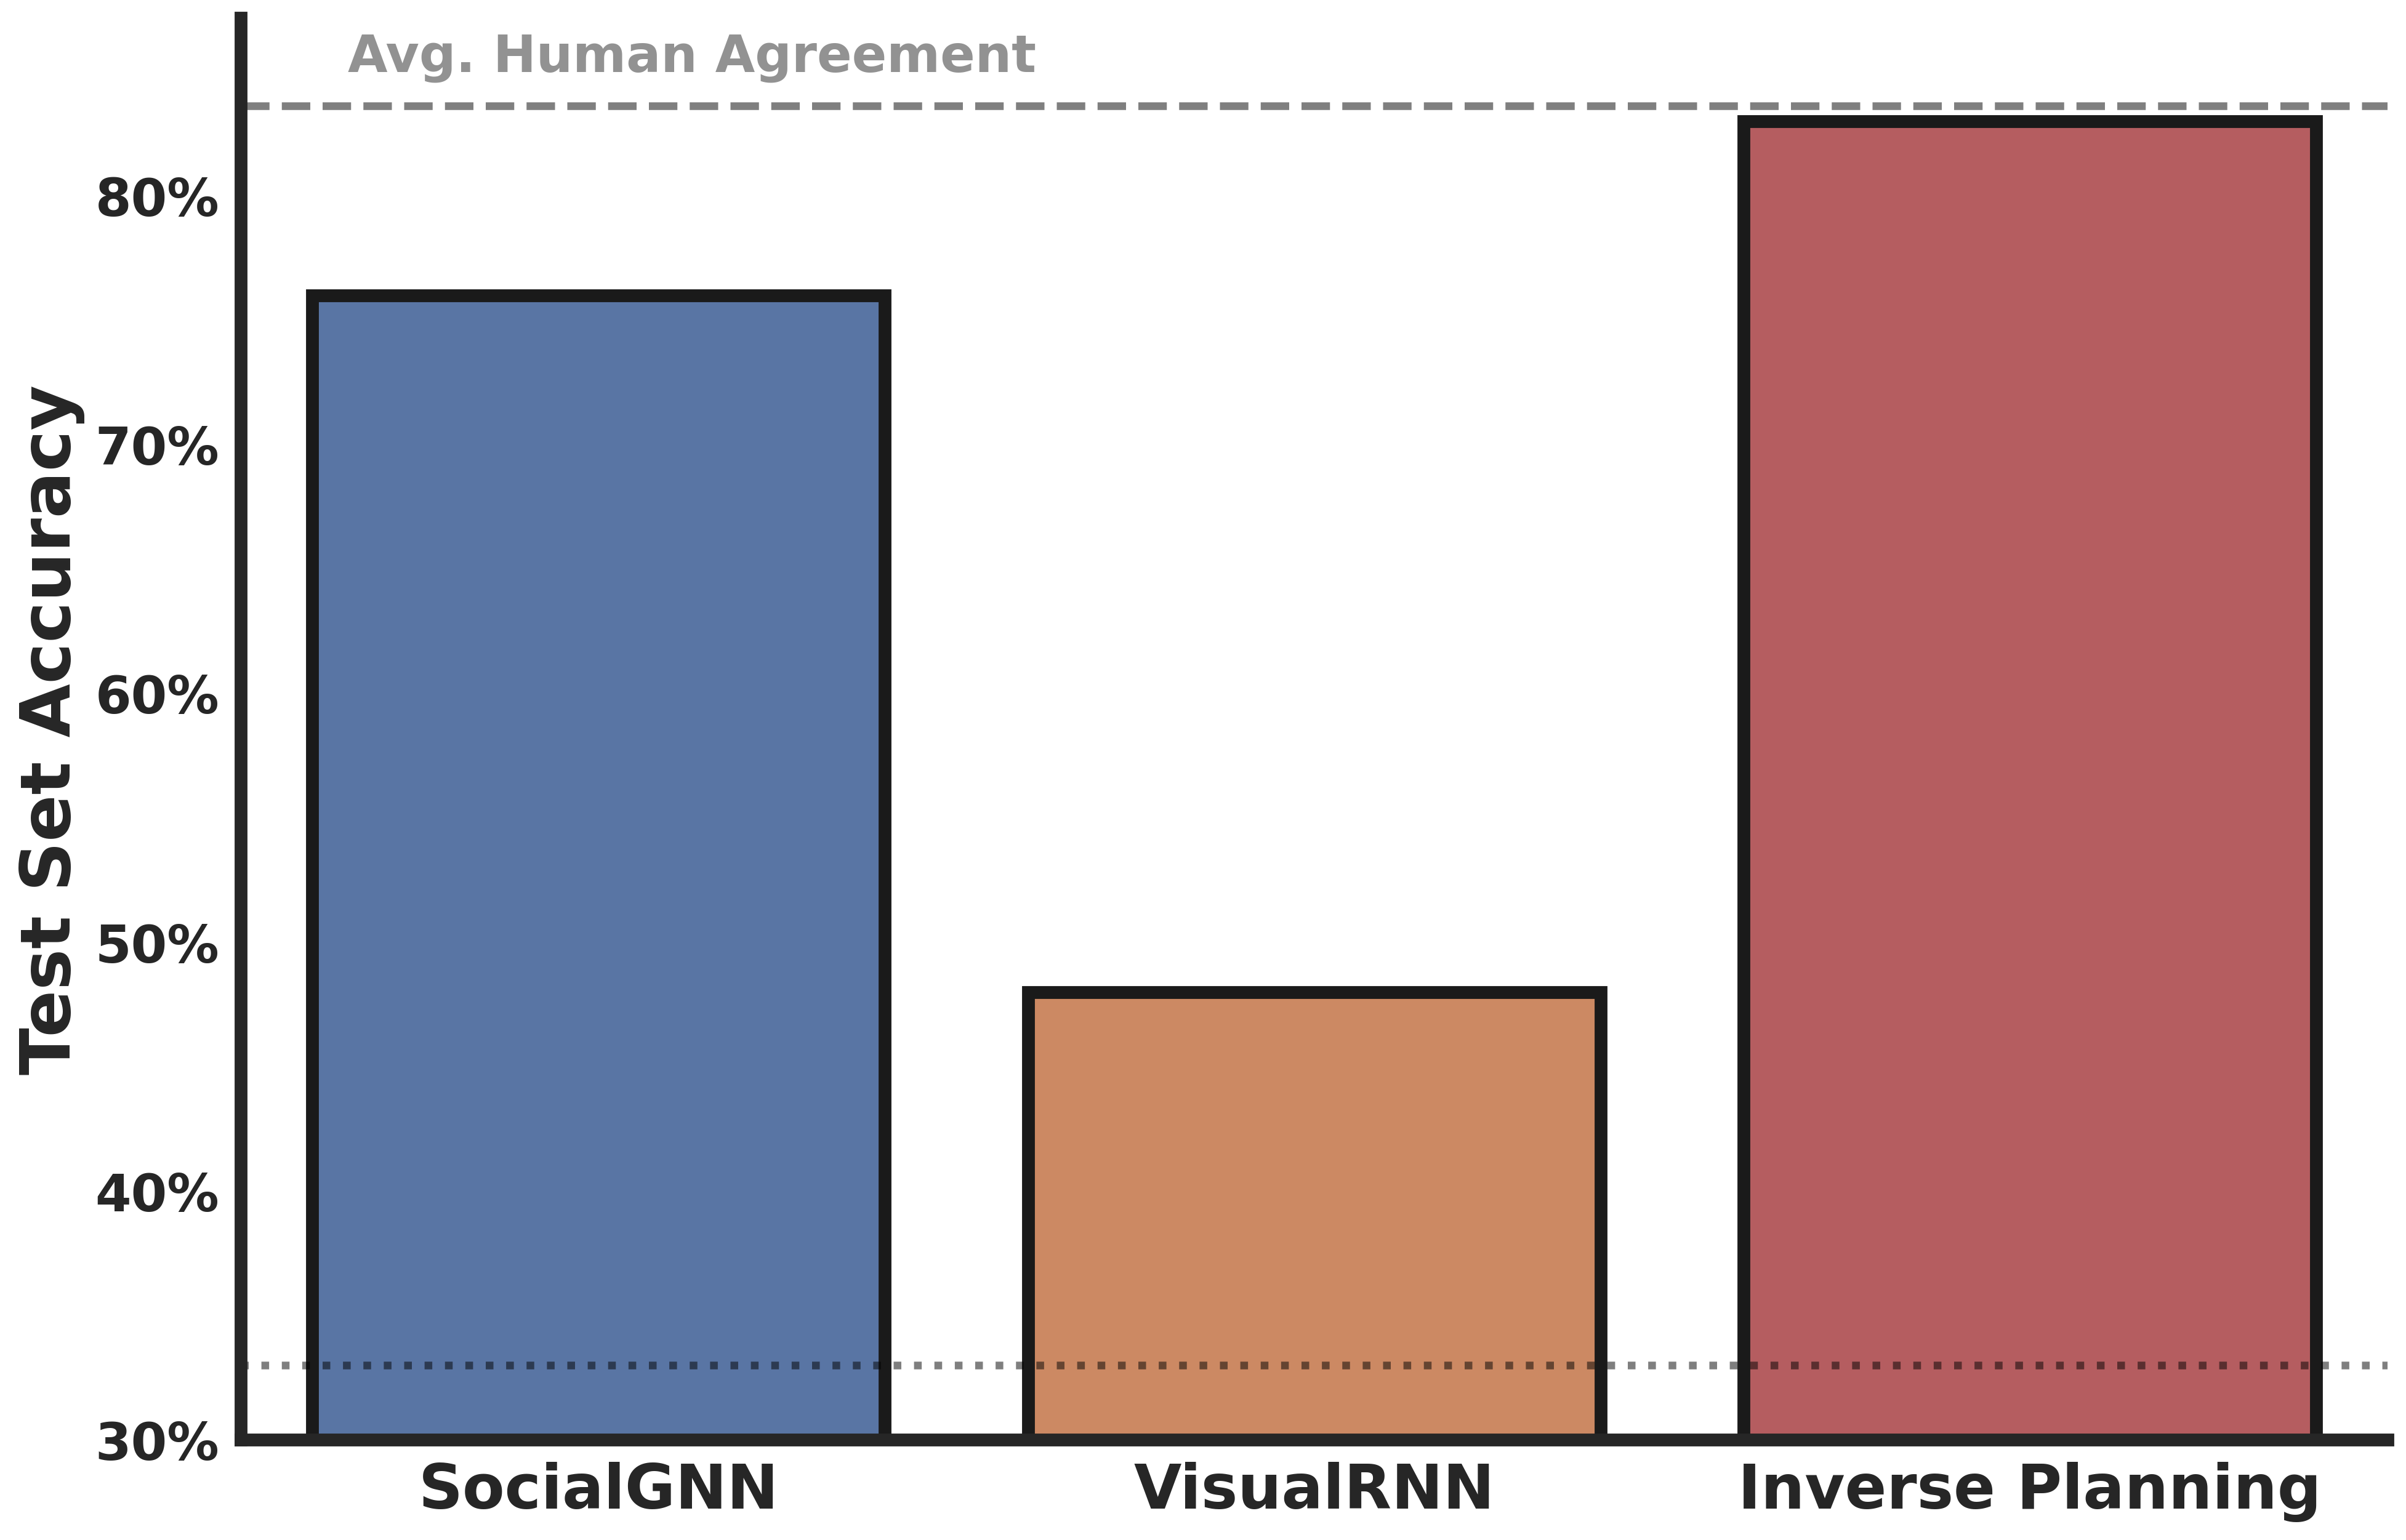

In [115]:
#(added wall and landmark coordinates)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

'''
SocialGNN_E_16 = {'testset': [0.76]}
CueBasedLSTM_16 = {'testset': [0.48]}
SIMPLE = {'testset': [0.9]}
'''

SocialGNN_E_16 = {'testset': [acc['SocialGNN']['HR']]}
CueBasedLSTM_16 = {'testset': [acc['CueBasedLSTM']['HR']]}
SIMPLE = {'testset': [acc['SIMPLE']['HR']]}

df = pd.concat([pd.DataFrame(SocialGNN_E_16), pd.DataFrame(CueBasedLSTM_16), pd.DataFrame(SIMPLE)], keys=['SocialGNN', 'VisualRNN', 'Inverse Planning']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)
display(df)

# Plots
#sns.set(rc={'figure.figsize':(20,14), 'font.weight':'normal'}, font_scale=3, style = "white")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2.3, style="white")
plt.rcParams["figure.figsize"] = (15,10)

p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
f = sns.barplot(x="model",y="testset_accuracy", data=df, palette = p, linewidth = 5, edgecolor ='k')

f.axhline(0.33, color = "black", ls = ":", alpha = 0.5, linewidth = 3)
f.axhline(0.8363, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(-.35, 0.85, "Avg. Human Agreement", fontsize=20, weight="bold", alpha = 0.5)

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 20) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)
f.set_yticklabels(f.get_yticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=27)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.gca().set_ylim(bottom=0.3)

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from google.colab import files
plt.savefig("PHASE_generalisationset.svg", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_generalisationset.svg")

plt.show()

## Computational Resources Plot

In [116]:
# time in sec, memory is in MB
SocialGNN_E_25 = {'run_time' : 16, 'memory': 1.32} 
CueBasedLSTM_6_25 = {'run_time' : 4, 'memory': 1.32}
SIMPLE_25 = {'run_time' : 98513, 'memory': 48280}   # this is 27hrs, 21.9mins

mydicts = [SocialGNN_E_25, CueBasedLSTM_6_25, SIMPLE_25]

df = pd.DataFrame.from_records(mydicts).fillna(0)
df.index = ['SocialGNN', 'VisualRNN', 'Inverse Planning']
display(df)

# is the _25 just rnadom naming to make it distinct from accruacy dictionaries??

,run_time,memory
SocialGNN,16,1.32
VisualRNN,4,1.32
Inverse Planning,98513,48280.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

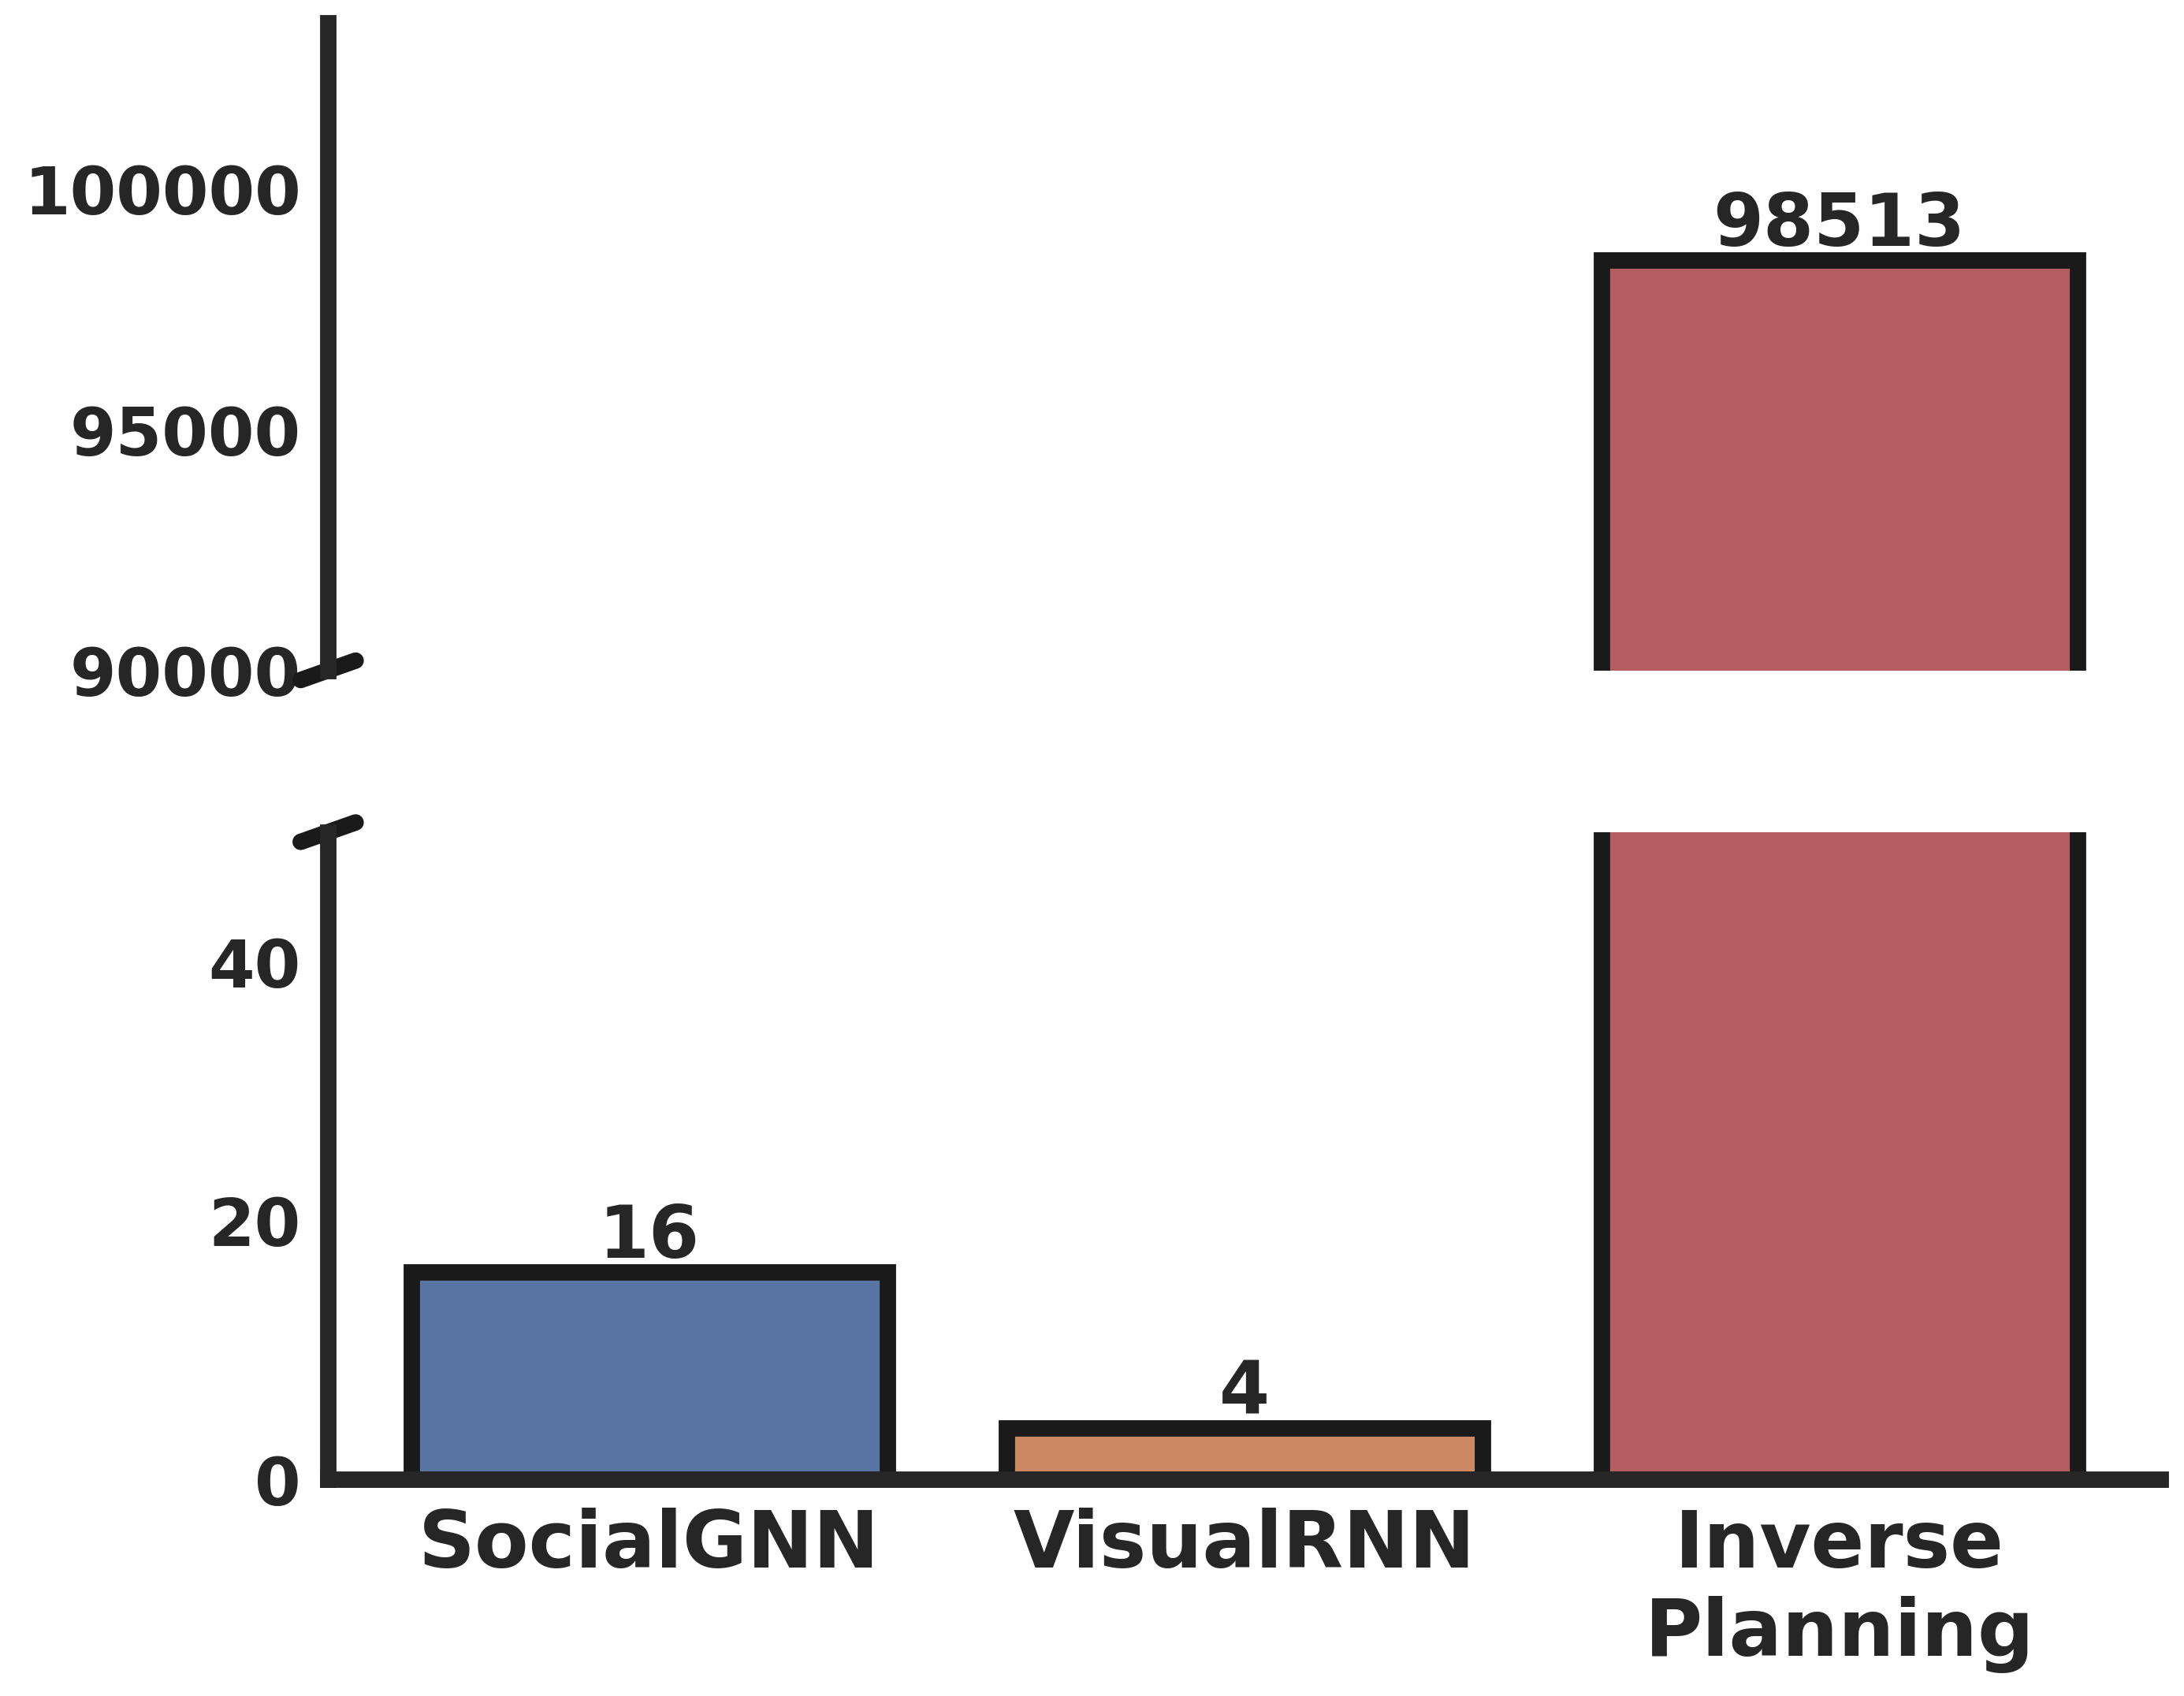

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

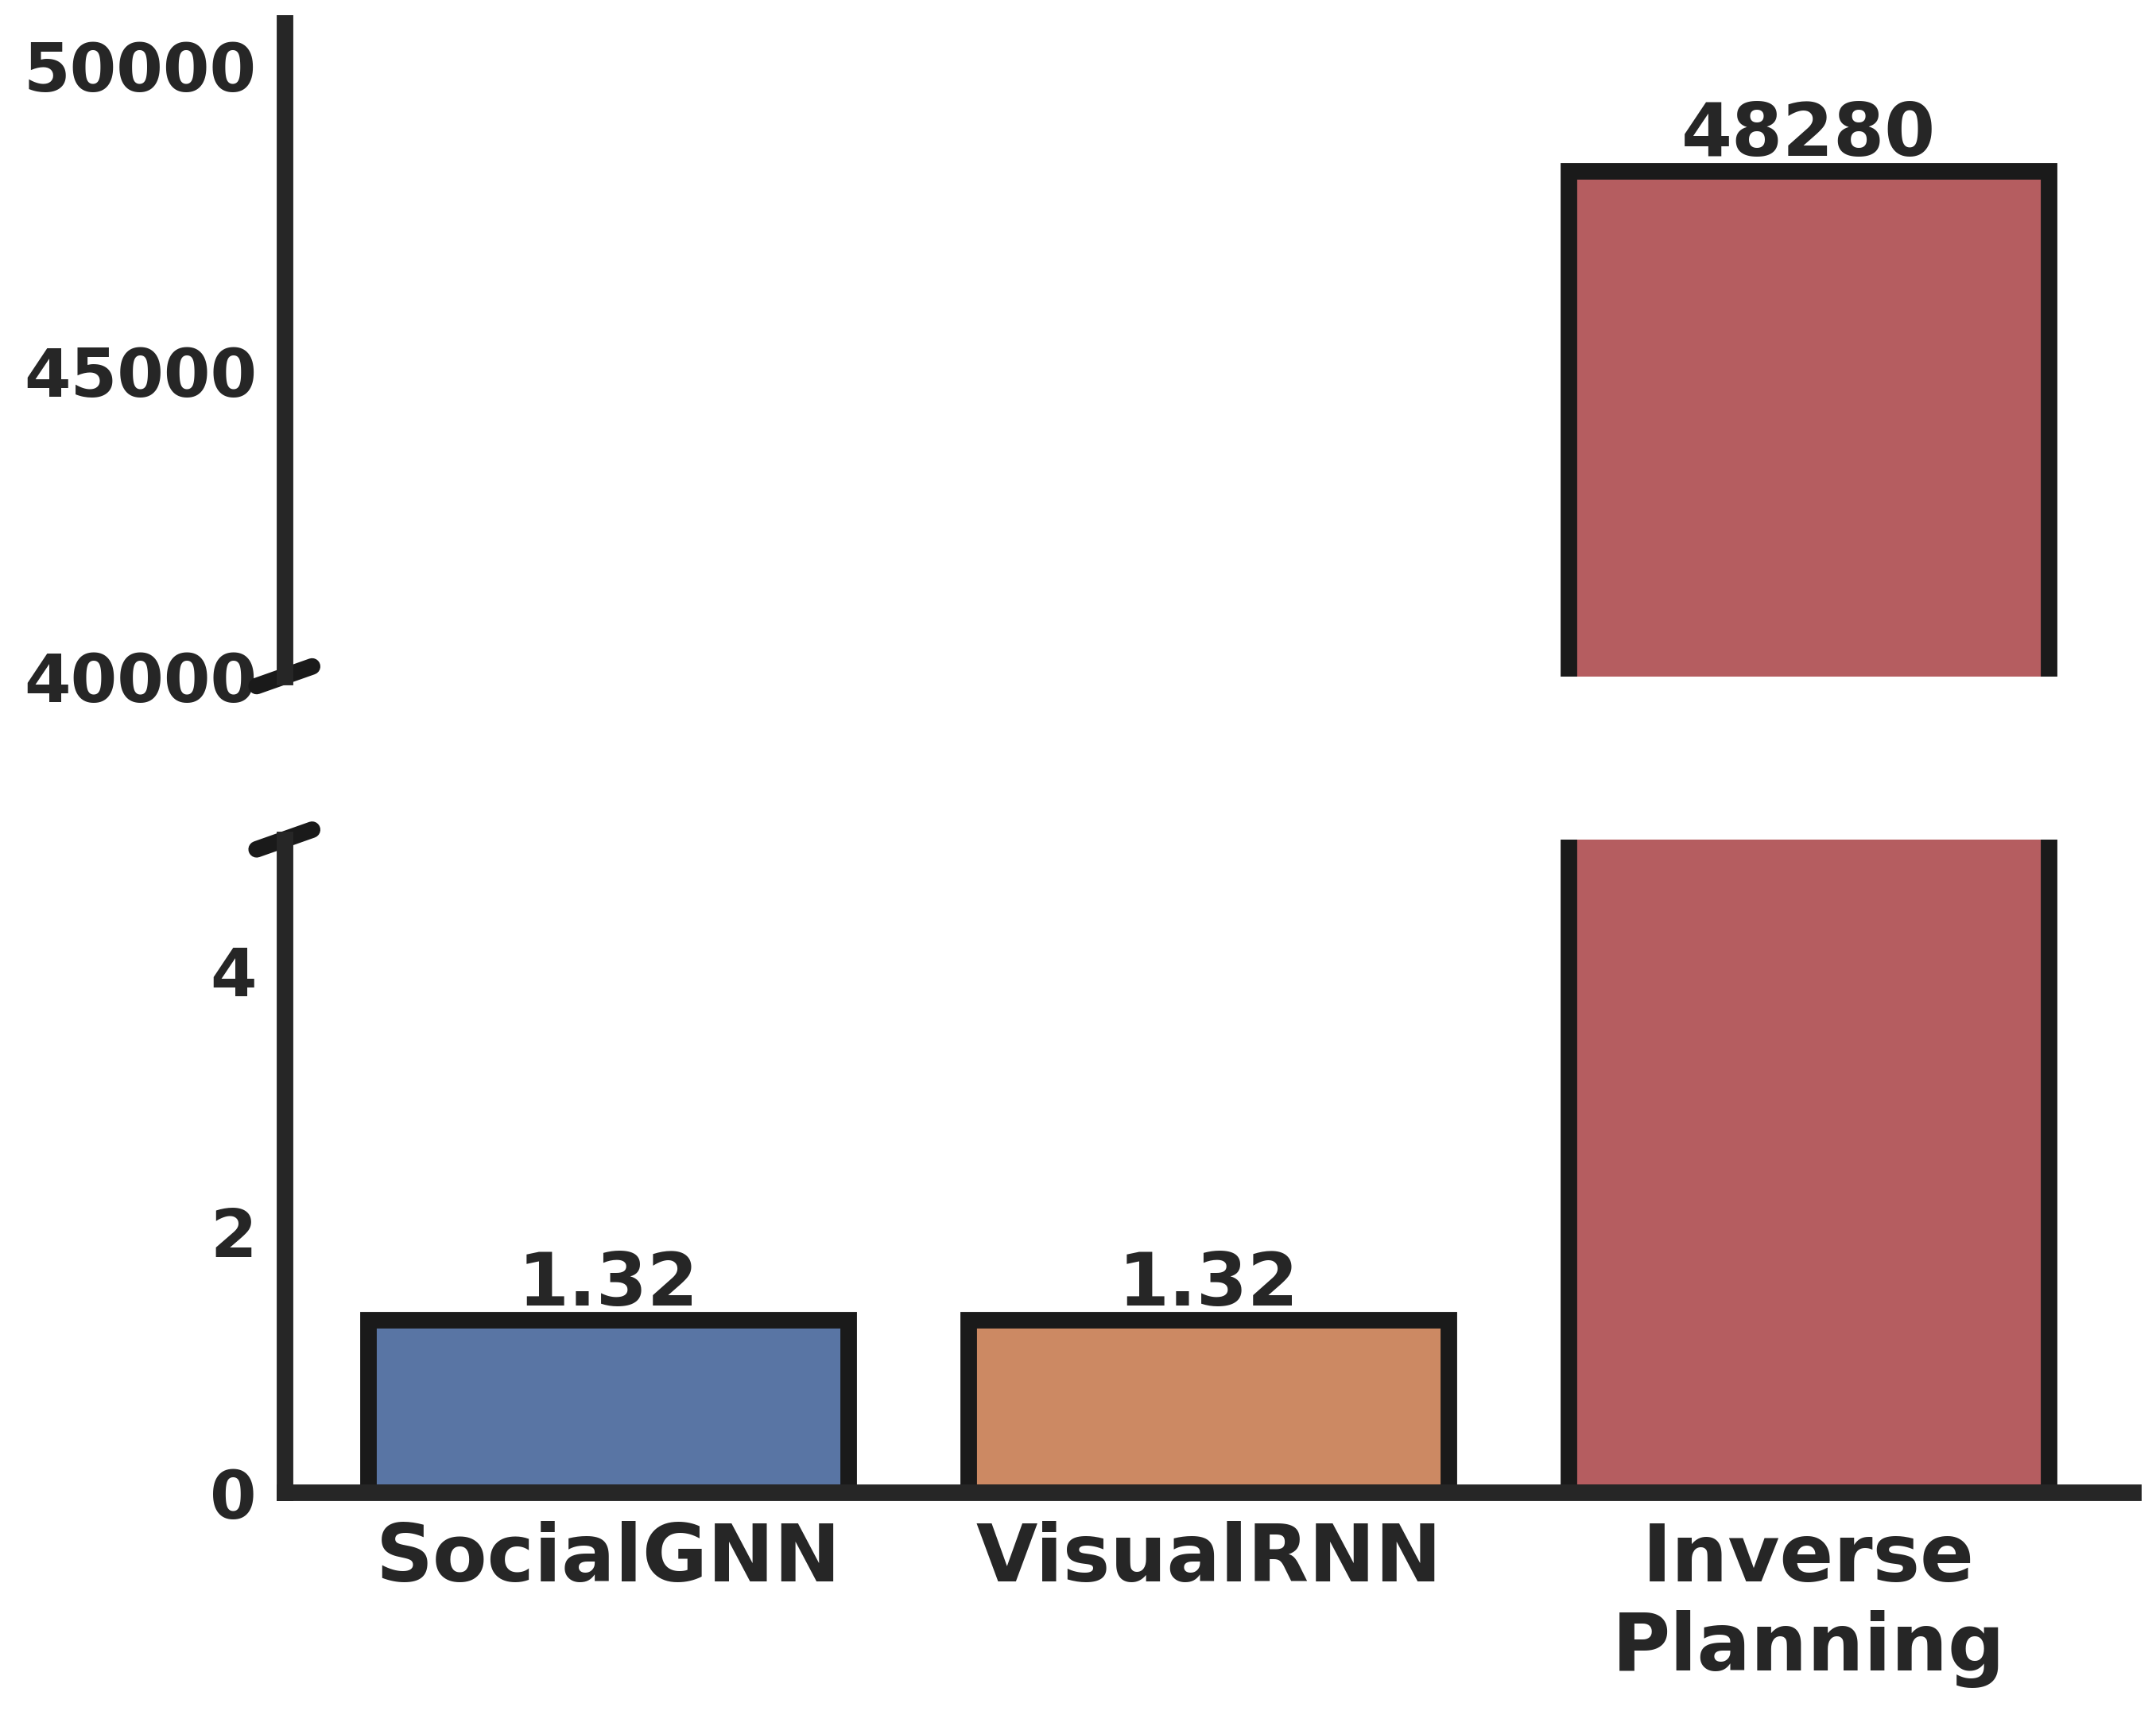

In [117]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2.3, style="white")
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.weight"] = "bold"

### Run Time
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.25})
p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
a = sns.barplot(x = df.index, y="run_time", data=df, ax=ax_top, palette = p, linewidth = 5, edgecolor ='k')
b = sns.barplot(x = df.index, y="run_time", data=df, ax=ax_bottom, palette = p, linewidth = 5, edgecolor ='k')
a.bar_label(a.containers[0], fontweight = "bold")
b.bar_label(b.containers[0], fontweight = "bold")
ax_top.set_ylim(bottom=90000)  
ax_bottom.set_ylim(0,50)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)
ax_top.spines['left'].set_linewidth(5)
ax_bottom.spines['left'].set_linewidth(5)
ax_bottom.spines['bottom'].set_linewidth(5)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth = 5)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

a.set(xlabel=None)
b.set(xlabel=None)
a.set(ylabel=None)
b.set(ylabel=None)
#f.supylabel('Run-Time (sec)')

import textwrap
ax_bottom.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in ax_bottom.get_xticklabels())
ax_bottom.set_xticklabels(ax_bottom.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)

from google.colab import files
plt.savefig("run-time.svg", bbox_inches = 'tight', transparent = True)
#files.download("run-time.svg")
plt.show()


### Memory
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.25})
p = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)]
a = sns.barplot(x = df.index, y="memory", data=df, ax=ax_top, palette = p, linewidth = 5, edgecolor ='k')
b = sns.barplot(x = df.index, y="memory", data=df, ax=ax_bottom, palette = p, linewidth = 5, edgecolor ='k')
a.bar_label(a.containers[0], fontweight = "bold")
b.bar_label(b.containers[0], fontweight = "bold")
ax_top.set_ylim(bottom=40000)  
ax_bottom.set_ylim(0,5)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)
ax_top.spines['left'].set_linewidth(5)
ax_bottom.spines['left'].set_linewidth(5)
ax_bottom.spines['bottom'].set_linewidth(5)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=5)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

a.set(xlabel=None)
b.set(xlabel=None)
a.set(ylabel=None)
b.set(ylabel=None)
#f.supylabel('Run-Time (sec)')

import textwrap
ax_bottom.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in ax_bottom.get_xticklabels())
ax_bottom.set_xticklabels(ax_bottom.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)

from google.colab import files
plt.savefig("memory.svg", bbox_inches = 'tight', transparent = True)
#files.download("memory.svg")
plt.show()

## Plot: Effect of increasing size and adding context information
(needs to be modified so it gets predictions + accuracies from files not hard coded)

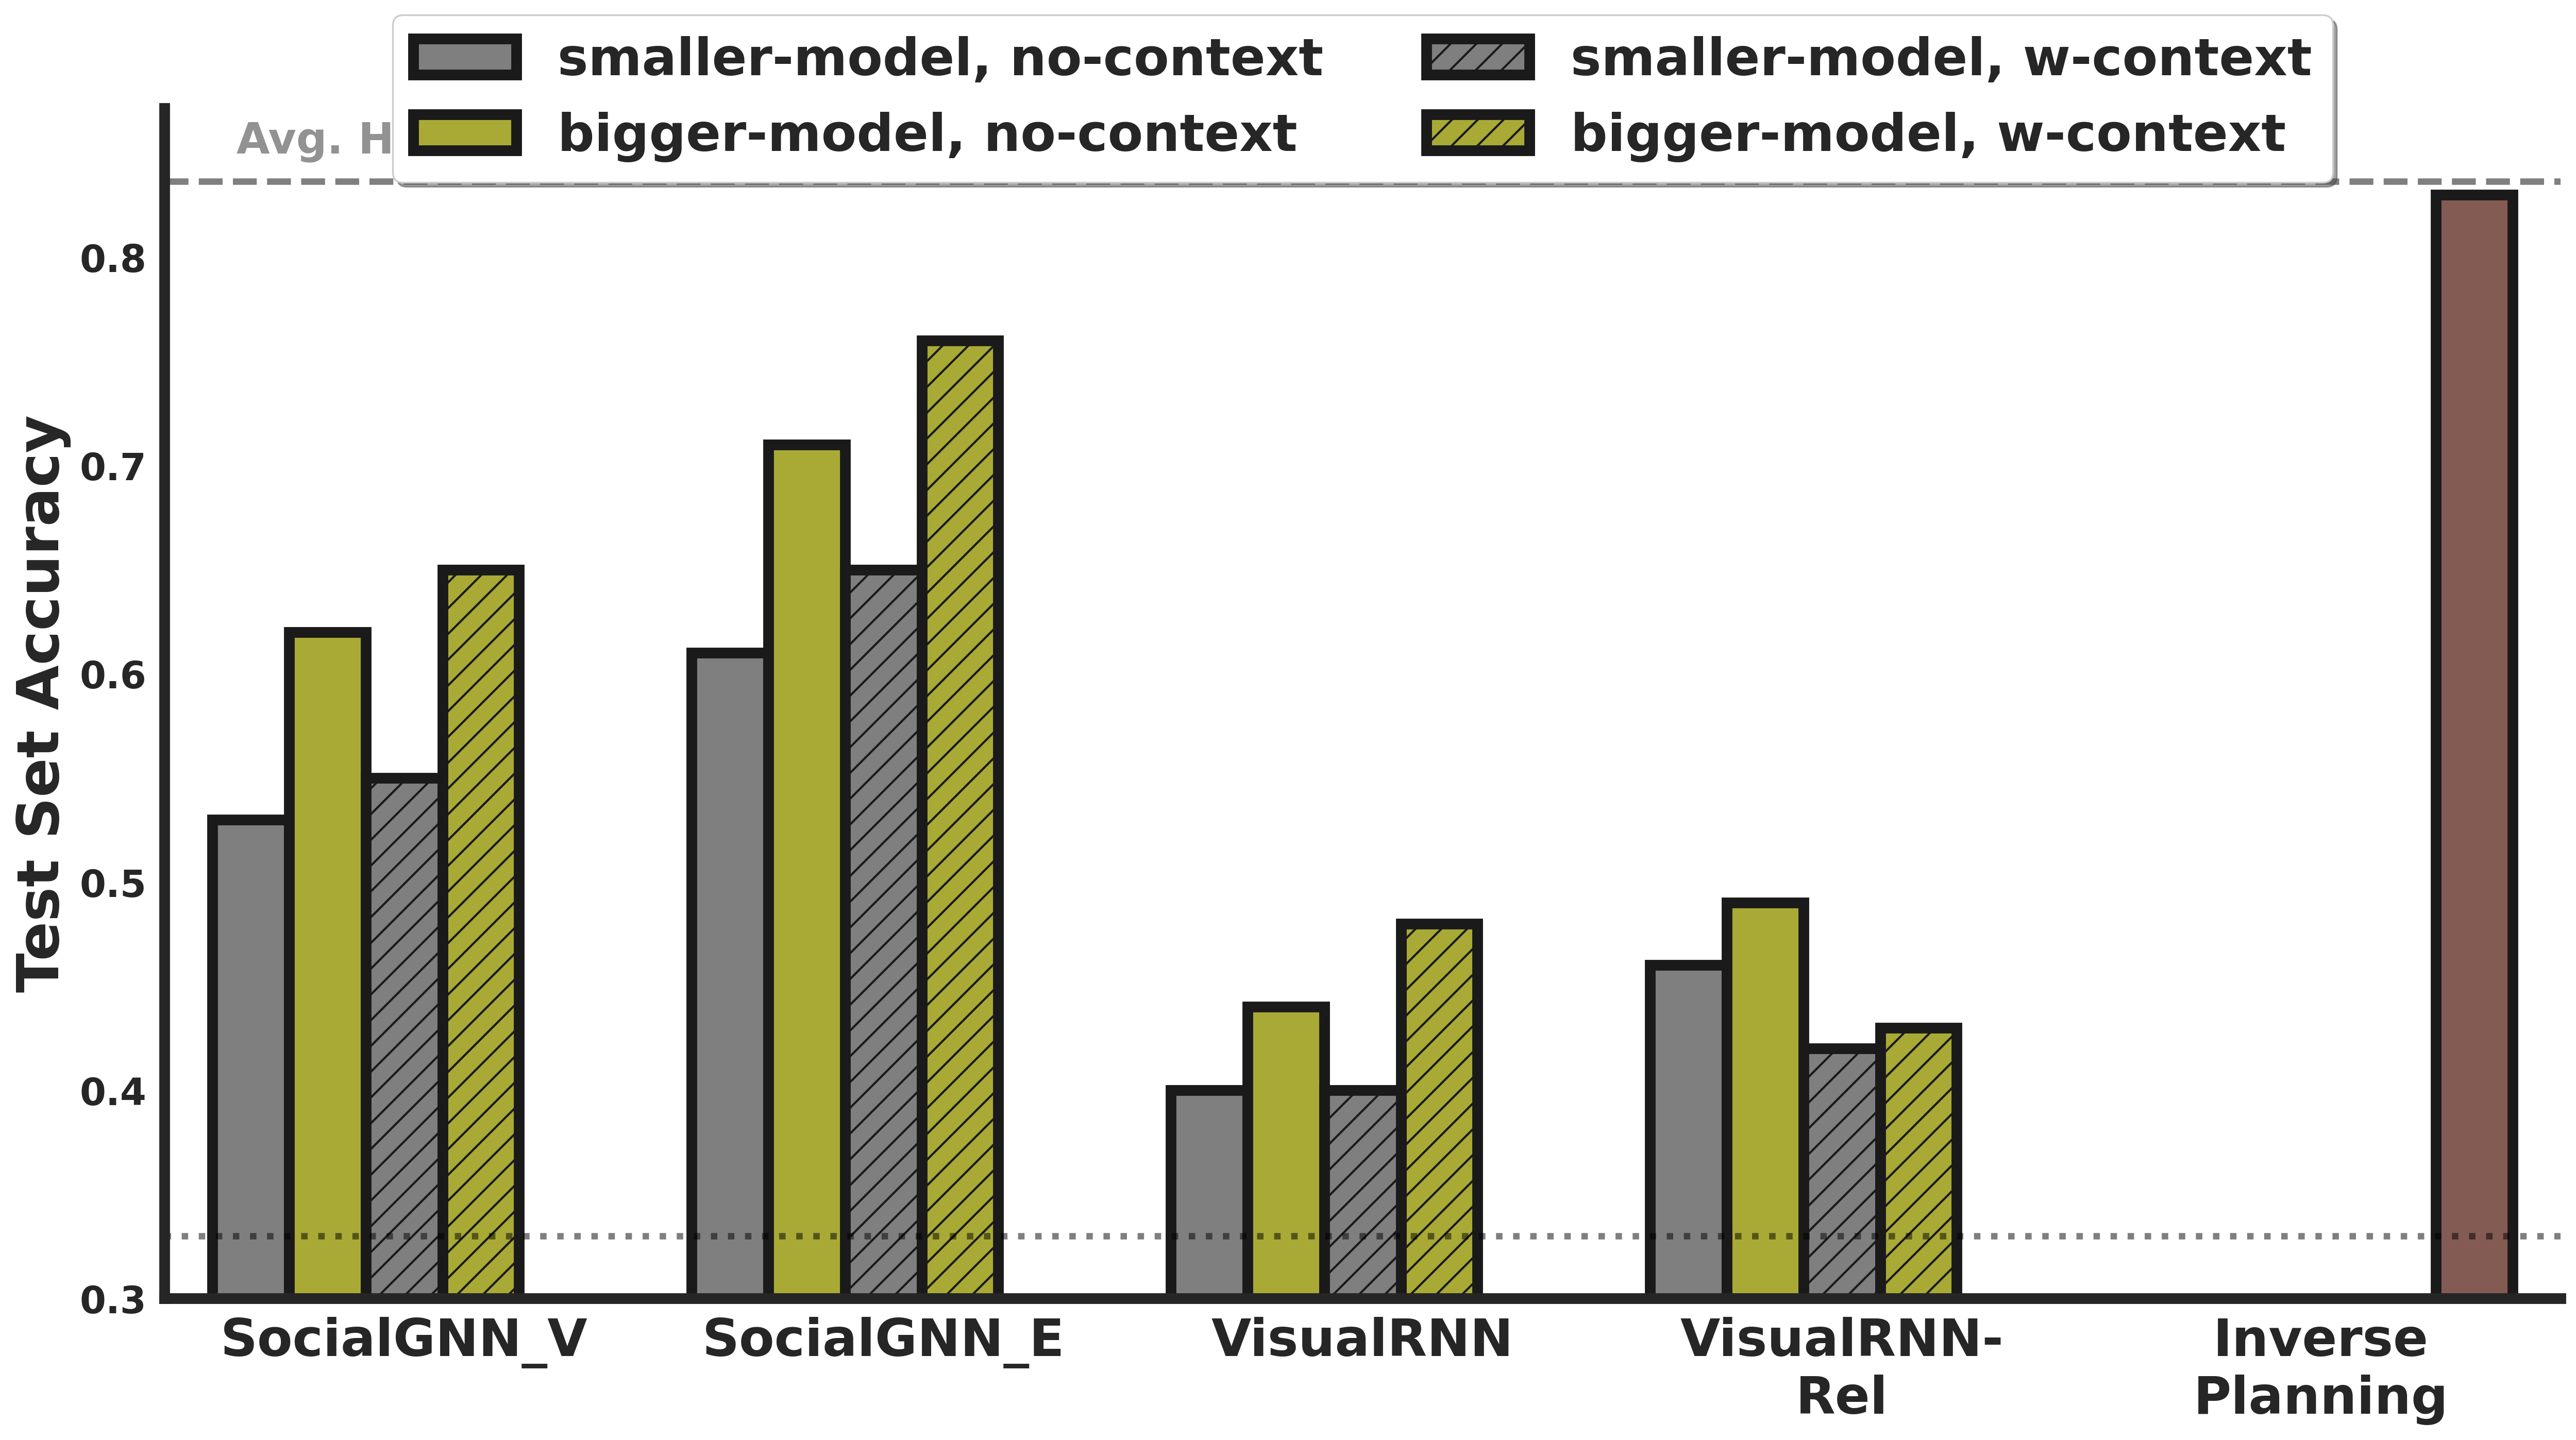

In [119]:
# All Models (w/o context)

SocialGNN_V_6 = {'testset': [0.53]}
SocialGNN_V_16 = {'testset': [0.62]}
SocialGNN_E_6 = {'testset': [0.61]}
SocialGNN_E_16 = {'testset': [0.71]}

CueBasedLSTM_6 = {'testset': [0.40]}
CueBasedLSTM_16 = {'testset': [0.44]}
CueBasedLSTM_Relation_6 = {'testset': [0.46]}
CueBasedLSTM_Relation_16 = {'testset': [0.49]}

# All Models (w context)
SocialGNN_V_6 = {'testset': [0.55]}
SocialGNN_V_16 = {'testset': [0.65]}
SocialGNN_E_6 = {'testset': [0.65]}
SocialGNN_E_16 = {'testset': [0.76]}

CueBasedLSTM_6 = {'testset': [0.40]}
CueBasedLSTM_16 = {'testset': [0.48]}
CueBasedLSTM_Relation_6 = {'testset': [0.42]}
CueBasedLSTM_Relation_16 = {'testset': [0.43]}

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

d = [{'model': 'SocialGNN_V', 'size':6, 'accuracy':0.53, 'w_context': 'no', "type": "smaller-model, no-context"}, 
     {'model': 'SocialGNN_V', 'size':16, 'accuracy':0.62, 'w_context': 'no', "type": "bigger-model, no-context"}, 
     {'model': 'SocialGNN_E', 'size':6, 'accuracy':0.61, 'w_context': 'no', "type": "smaller-model, no-context"}, 
     {'model': 'SocialGNN_E', 'size':16, 'accuracy':0.71, 'w_context': 'no', "type": "bigger-model, no-context"},
     {'model': 'SocialGNN_V', 'size':6, 'accuracy':0.55, 'w_context': 'yes', "type": "smaller-model, w-context"}, 
     {'model': 'SocialGNN_V', 'size':16, 'accuracy':0.65, 'w_context': 'yes', "type": "bigger-model, w-context"}, 
     {'model': 'SocialGNN_E', 'size':6, 'accuracy':0.65, 'w_context': 'yes', "type": "smaller-model, w-context"}, 
     {'model': 'SocialGNN_E', 'size':16, 'accuracy':0.76, 'w_context': 'yes', "type": "bigger-model, w-context"},

     {'model': 'VisualRNN', 'size':6, 'accuracy':0.4, 'w_context': 'no', "type": "smaller-model, no-context"}, 
     {'model': 'VisualRNN', 'size':16, 'accuracy':0.44, 'w_context': 'no', "type": "bigger-model, no-context"}, 
     {'model': 'VisualRNN-Rel', 'size':6, 'accuracy':0.46, 'w_context': 'no', "type": "smaller-model, no-context"}, 
     {'model': 'VisualRNN-Rel', 'size':16, 'accuracy':0.49, 'w_context': 'no', "type": "bigger-model, no-context"},
     {'model': 'VisualRNN', 'size':6, 'accuracy':0.4, 'w_context': 'yes', "type": "smaller-model, w-context"}, 
     {'model': 'VisualRNN', 'size':16, 'accuracy':0.48, 'w_context': 'yes', "type": "bigger-model, w-context"}, 
     {'model': 'VisualRNN-Rel', 'size':6, 'accuracy':0.42, 'w_context': 'yes', "type": "smaller-model, w-context"}, 
     {'model': 'VisualRNN-Rel', 'size':16, 'accuracy':0.43, 'w_context': 'yes', "type": "bigger-model, w-context"},
     
     {'model': 'Inverse Planning', 'accuracy':0.83, 'type':'-'}]

df = pd.DataFrame.from_records(d)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (20,10)

p = {
    "smaller-model, no-context": 'tab:grey',
    "bigger-model, no-context": 'tab:olive',
    "smaller-model, w-context": 'tab:grey',
    "bigger-model, w-context": 'tab:olive',
    "-": 'tab:brown'}
f = sns.barplot(data=df, x="model", y="accuracy", hue="type", palette = p, linewidth = 5, edgecolor ='k')

# bar design
import itertools
num_locations = 5
hatches = itertools.cycle(['', '', '//', '//', '', '\\', '*', 'o', 'O', '.'])
for i, bar in enumerate(f.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)

# legend
handles, labels = f.get_legend_handles_labels()
f.legend(fontsize= 24, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, shadow=True, handles=handles[:-1], labels=labels[:-1])

# human agreement and chance accuracy
f.axhline(0.33, color = "black", ls = ":", alpha = 0.5, linewidth = 3)
f.axhline(0.8363, color = "black", ls = "--", alpha = 0.5, linewidth = 3)
f.text(-.35, 0.85, "Avg. Human Agreement", fontsize=20, weight="bold", alpha = 0.5)

# axes
import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=24)
#f.set_yticklabels(f.get_yticklabels(),rotation = 0, weight = "bold", fontsize = 24)
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=27)

plt.gca().set_ylim(bottom=0.3)
sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from google.colab import files
plt.savefig("PHASE_generalisationset_extendedmodels.svg", bbox_inches = 'tight', transparent = True)
#files.download("PHASE_generalisationset_extendedmodels.svg")

plt.show()

# **Human Gaze Communication Dataset**
(needs to be modified so it gets predictions + accuracies from files not hard coded)

## 2 Way

In [ ]:
#unweighted
#SocialGNN_V = {'cross_val': [0.7042857142857143, 0.6618045112781956, 0.7175, 0.6599999999999999, 0.6741666666666667, 0.70625, 0.6829166666666666, 0.6872096908939014, 0.7041071428571429, 0.6950000000000001], 'entire_trainset': [0.773611111111111, 0.7792063492063492, 0.7541666666666667, 0.6865740740740741, 0.8037280701754387, 0.7146464646464646, 0.7675925925925927, 0.8054945054945055, 0.7097222222222221, 0.7250000000000001], 'testset': [0.6450549450549451, 0.6401709401709402, 0.6335664335664336, 0.5999999999999999, 0.7330882352941178, 0.6461538461538462, 0.7692307692307693, 0.6023809523809524, 0.5478021978021977, 0.6538461538461539]}

#CueBasedLSTM_6 = {'cross_val': [0.5725, 0.6296240601503759, 0.655, 0.6399999999999999, 0.6179166666666667, 0.66875, 0.5974999999999999, 0.5859649122807018, 0.6248214285714286, 0.6125], 'entire_trainset': [0.6111111111111112, 0.6293650793650795, 0.6083333333333334, 0.6199074074074074, 0.616593567251462, 0.6296717171717172, 0.5972222222222222, 0.5868131868131867, 0.6277777777777778, 0.6076388888888888], 'testset': [0.610989010989011, 0.5440170940170941, 0.6090909090909092, 0.5692307692307692, 0.5737745098039215, 0.573076923076923, 0.6615384615384614, 0.6583333333333332, 0.5401098901098901, 0.5884615384615385]}

#CueBasedLSTM_Relation_6 = {'cross_val': [0.5539285714285714, 0.6296240601503759, 0.6575, 0.6399999999999999, 0.6179166666666667, 0.66875, 0.5900000000000001, 0.5859649122807018, 0.6248214285714286, 0.6125], 'entire_trainset': [0.6111111111111112, 0.6293650793650795, 0.6083333333333334, 0.6199074074074074, 0.616593567251462, 0.6296717171717172, 0.5972222222222222, 0.5868131868131867, 0.6277777777777778, 0.6076388888888888], 'testset': [0.610989010989011, 0.5440170940170941, 0.6090909090909092, 0.5692307692307692, 0.5737745098039215, 0.573076923076923, 0.6615384615384614, 0.6583333333333332, 0.5401098901098901, 0.5884615384615385]}

#weighted
#SocialGNN_V = {'cross_val': [0.6642857142857144, 0.6438345864661654, 0.6824999999999999, 0.7224999999999999, 0.6329166666666668, 0.6929166666666667, 0.6537499999999999, 0.6351461988304093, 0.7373214285714285, 0.64375], 'entire_trainset': [0.848611111111111, 0.7568253968253968, 0.7833333333333333, 0.7495370370370371, 0.7288011695906432, 0.7593434343434343, 0.8217592592592593, 0.7504395604395605, 0.8, 0.7770833333333333], 'testset': [0.7065934065934066, 0.5952991452991453, 0.6573426573426573, 0.6269230769230769, 0.6865196078431373, 0.5961538461538461, 0.7923076923076924, 0.6285714285714287, 0.681868131868132, 0.6653846153846152]}
SocialGNN_V = {'testset': [0.7047244094488189, 0.5968992248062015, 0.6613545816733067, 0.636, 0.6877637130801688, 0.6204081632653061, 0.7759336099585062, 0.6045627376425855, 0.6811023622047244, 0.6612903225806451]}

#CueBasedLSTM_6 = {'cross_val': [0.47874999999999995, 0.6167669172932331, 0.5925, 0.6225, 0.6041666666666666, 0.66875, 0.47125000000000006, 0.4140350877192983, 0.5919642857142857, 0.6125], 'entire_trainset': [0.3888888888888889, 0.6293650793650795, 0.6083333333333334, 0.6199074074074074, 0.616593567251462, 0.6296717171717172, 0.5972222222222222, 0.4131868131868132, 0.4833333333333333, 0.6076388888888888], 'testset': [0.389010989010989, 0.5440170940170941, 0.6090909090909092, 0.5692307692307692, 0.5737745098039215, 0.573076923076923, 0.6615384615384614, 0.3416666666666667, 0.5307692307692309, 0.5884615384615385]}
CueBasedLSTM_6 = {'testset': [0.3779527559055118, 0.5426356589147286, 0.601593625498008, 0.572, 0.5780590717299579, 0.5469387755102041, 0.6348547717842323, 0.34220532319391633, 0.531496062992126, 0.5806451612903226]}

#CueBasedLSTM_Relation_6 = {'cross_val': [0.47857142857142854, 0.6296240601503759, 0.59375, 0.6399999999999999, 0.6179166666666667, 0.66875, 0.4575, 0.4788220551378446, 0.6248214285714286, 0.6125], 'entire_trainset': [0.6111111111111112, 0.6293650793650795, 0.6055555555555556, 0.6199074074074074, 0.616593567251462, 0.6296717171717172, 0.40277777777777785, 0.5896703296703296, 0.6277777777777778, 0.6076388888888888], 'testset': [0.610989010989011, 0.5440170940170941, 0.6129370629370631, 0.5692307692307692, 0.5737745098039215, 0.573076923076923, 0.3384615384615385, 0.6476190476190476, 0.5401098901098901, 0.5884615384615385]}
CueBasedLSTM_Relation_6 = {'testset': [0.6220472440944882, 0.5426356589147286, 0.6055776892430279, 0.572, 0.5780590717299579, 0.5469387755102041, 0.3651452282157676, 0.6463878326996197, 0.5393700787401575, 0.5806451612903226]}

In [ ]:
import numpy as np

print(np.mean(SocialGNN_V['testset']), np.mean(CueBasedLSTM_6['testset']), np.mean(CueBasedLSTM_Relation_6['testset']))

0.6630039124660263 0.5308381206819008 0.5598806740438275


In [ ]:
pip install statannotations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: t-test paired samples with Holm-Bonferroni correction, P_val:1.497e-03 t=4.496e+00
SocialGNN vs. VisualRNN-Rel: t-test paired samples with Holm-Bonferroni correction, P_val:2.192e-02 t=2.765e+00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

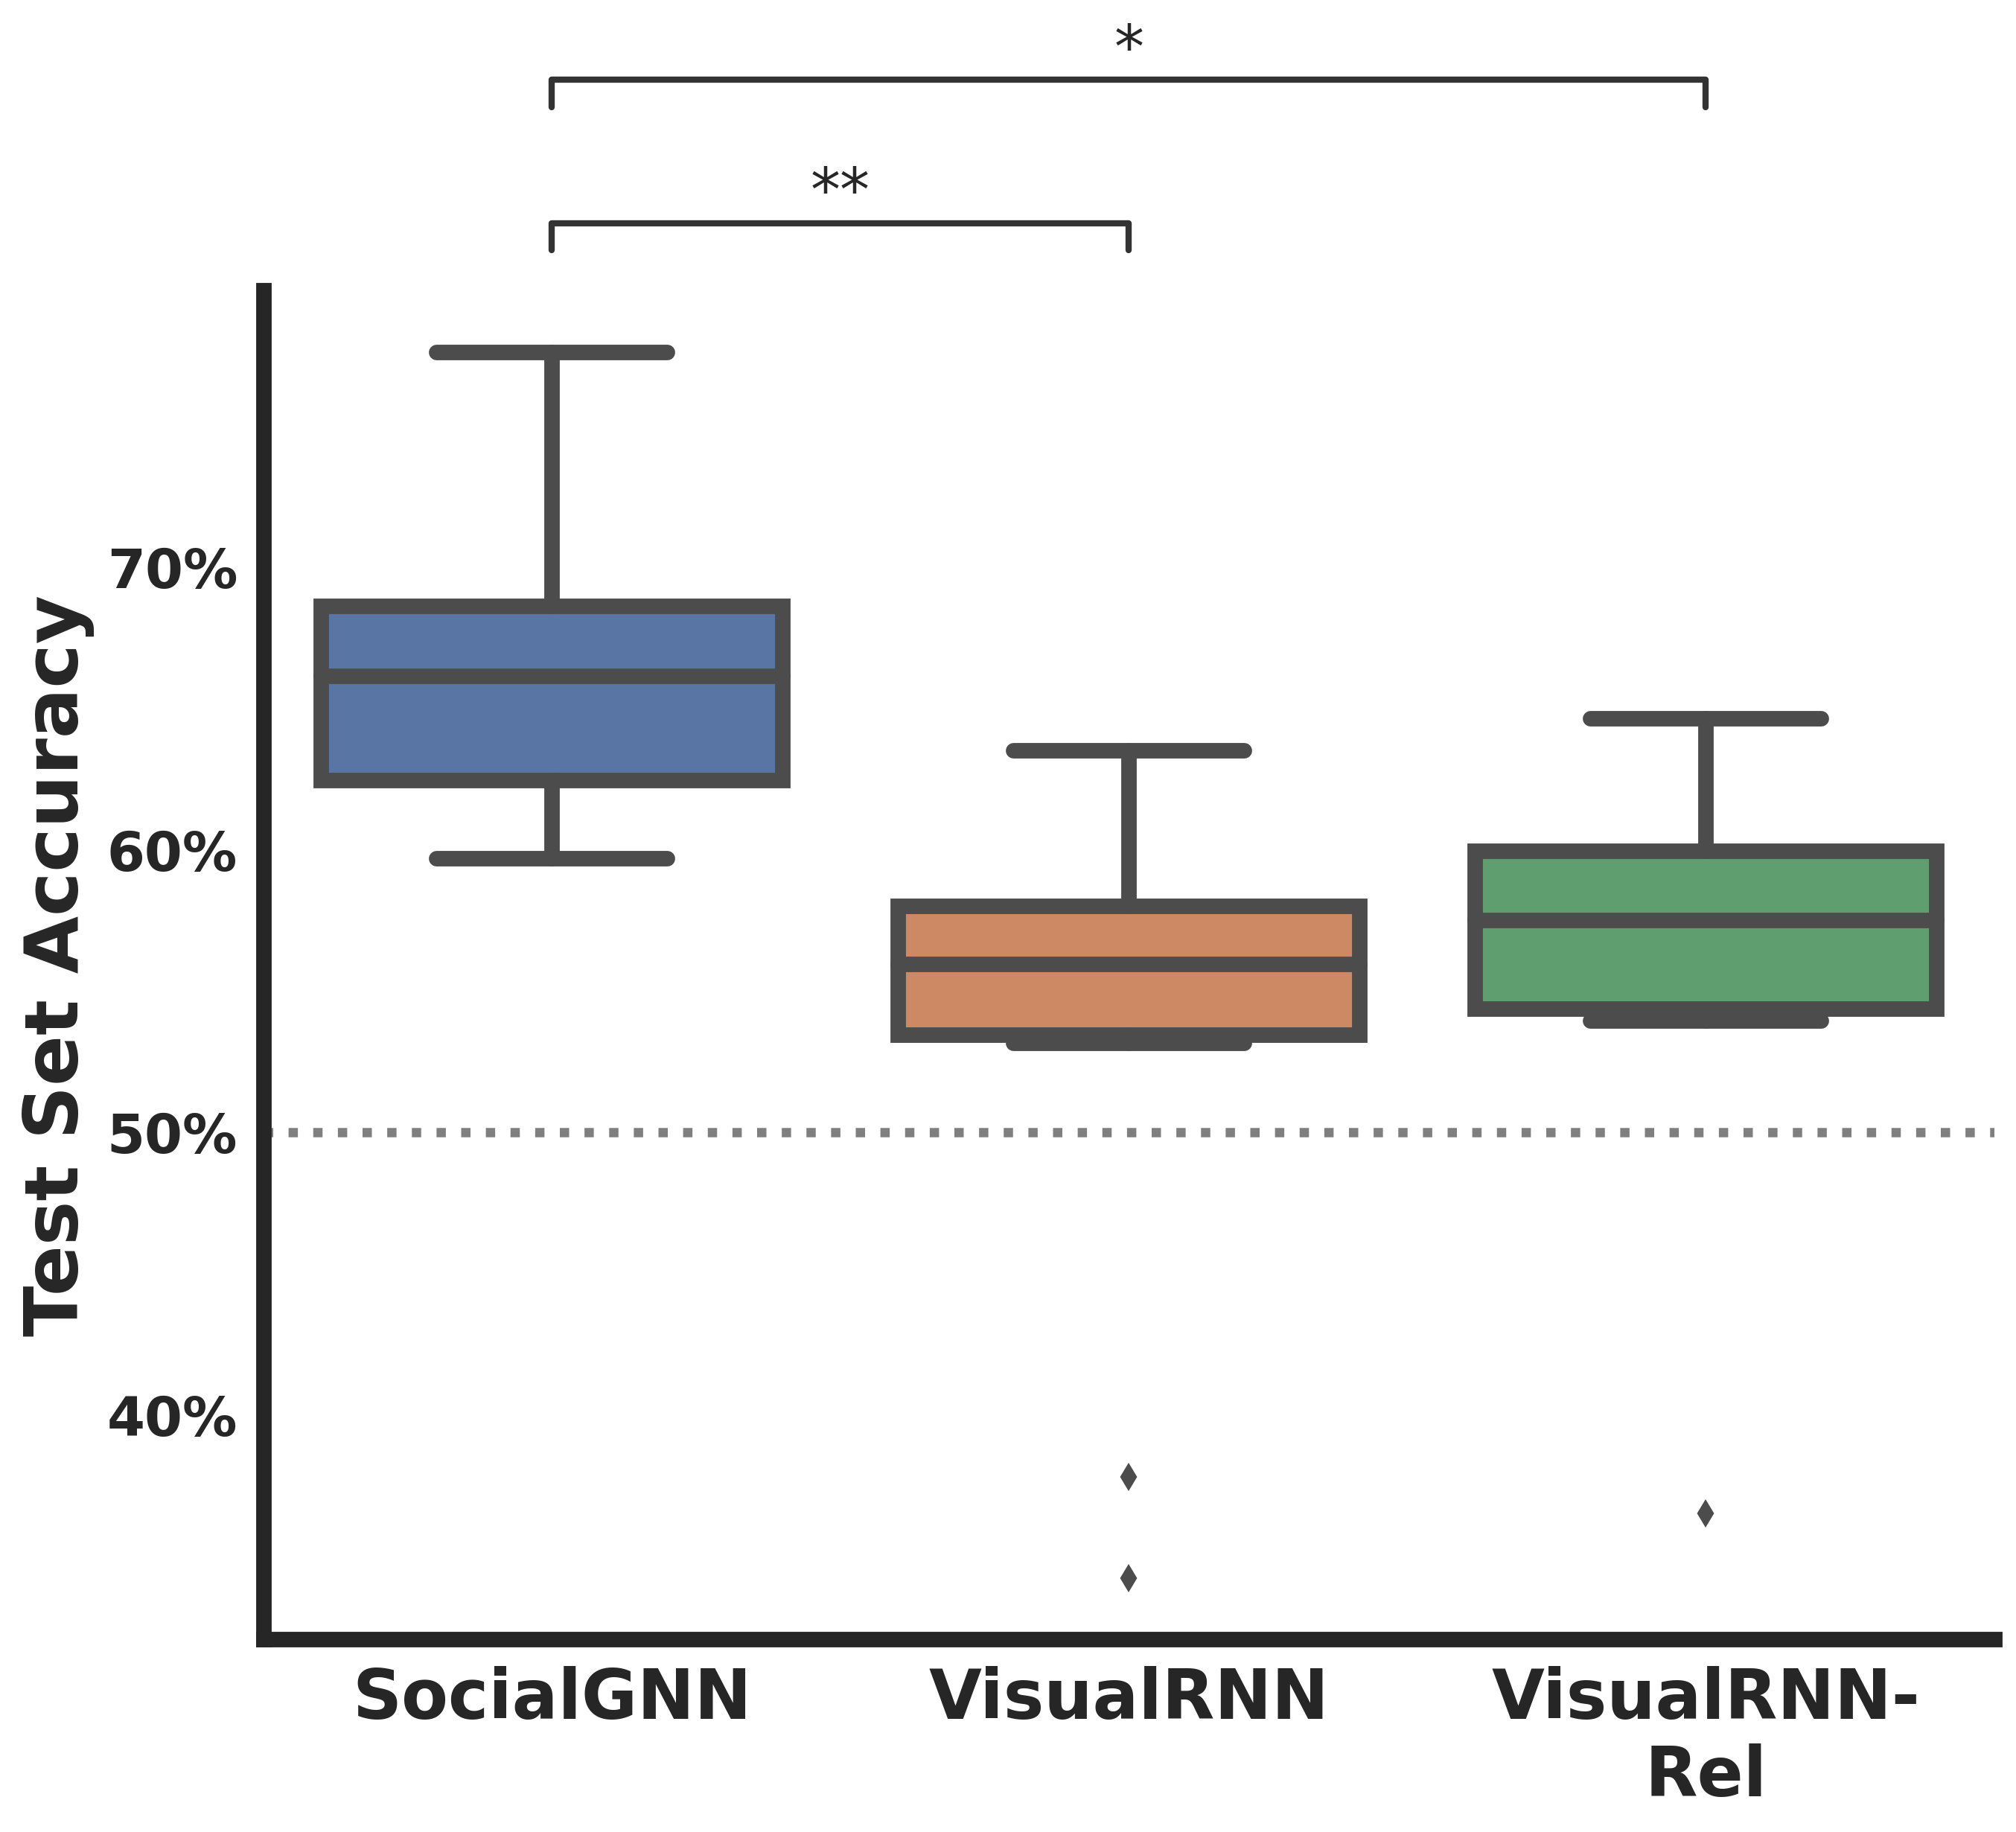

In [ ]:
from statannotations.Annotator import Annotator
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6)], keys=['SocialGNN','VisualRNN', 'VisualRNN-Rel']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300}, context = "paper", font_scale = 2, style="white")
plt.rcParams["figure.figsize"] = (10,8)

f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth = 5)
f.axhline(0.5, color = "black", ls = ":", alpha = 0.5, linewidth = 3) #alpha 0.8 for the poster

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel")]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
annotator.configure(comparisons_correction="HB", test='t-test_paired', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
annotator.apply_and_annotate()

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

from google.colab import files
plt.savefig("gaze_2.svg", bbox_inches = 'tight', transparent = False)
#files.download("gaze_2.svg")

plt.show()

## 5-way

In [ ]:
#SocialGNN_V = {'cross_val': [0.4994642857142857, 0.40706766917293236, 0.41125, 0.41125, 0.40708333333333335, 0.3279166666666667, 0.4454166666666667, 0.37411027568922306, 0.4755357142857143, 0.32249999999999995], 'entire_trainset': [0.5652777777777778, 0.41825396825396827, 0.4041666666666667, 0.5101851851851852, 0.5812134502923977, 0.4059343434343434, 0.5569444444444445, 0.36813186813186816, 0.5180555555555555, 0.4375], 'testset': [0.44890109890109886, 0.3329059829059829, 0.42027972027972027, 0.4, 0.5323529411764705, 0.36153846153846153, 0.5807692307692308, 0.29523809523809524, 0.40989010989010993, 0.3403846153846154]}
SocialGNN_V = {'testset': [0.452755905511811, 0.3333333333333333, 0.42231075697211157, 0.408, 0.5316455696202531, 0.37142857142857144, 0.5477178423236515, 0.29277566539923955, 0.4094488188976378, 0.3387096774193548]}

#CueBasedLSTM_6 = {'cross_val': [0.15767857142857142, 0.15345864661654135, 0.22125, 0.25125000000000003, 0.18, 0.13625, 0.17833333333333337, 0.3155722639933166, 0.22160714285714284, 0.21625], 'entire_trainset': [0.06944444444444445, 0.14142857142857143, 0.24444444444444446, 0.22268518518518515, 0.1351608187134503, 0.1453282828282828, 0.13333333333333333, 0.2428571428571428, 0.17361111111111113, 0.23749999999999996], 'testset': [0.061538461538461535, 0.11324786324786326, 0.23881118881118885, 0.18076923076923077, 0.14240196078431372, 0.1, 0.19615384615384615, 0.225, 0.16098901098901097, 0.23461538461538461]}
CueBasedLSTM_6 = {'testset': [0.06299212598425197, 0.1124031007751938, 0.23107569721115537, 0.18, 0.14345991561181434, 0.10612244897959183, 0.13278008298755187, 0.23954372623574144, 0.16141732283464566, 0.2217741935483871]}

#CueBasedLSTM_Relation_6 = {'cross_val': [0.15125, 0.20857142857142857, 0.175, 0.215, 0.19375, 0.1825, 0.3045833333333333, 0.2146783625730994, 0.25250000000000006, 0.18250000000000002], 'entire_trainset': [0.10416666666666667, 0.14142857142857143, 0.3888888888888889, 0.23796296296296296, 0.1351608187134503, 0.1453282828282828, 0.3, 0.1257142857142857, 0.26388888888888884, 0.24722222222222218], 'testset': [0.07087912087912088, 0.11324786324786326, 0.37937062937062926, 0.24999999999999997, 0.1556372549019608, 0.09615384615384616, 0.3153846153846154, 0.14285714285714285, 0.19725274725274727, 0.22692307692307695]}
CueBasedLSTM_Relation_6 = { 'testset': [0.07086614173228346, 0.1124031007751938, 0.38645418326693226, 0.248, 0.15611814345991562, 0.10204081632653061, 0.26141078838174275, 0.1520912547528517, 0.1968503937007874, 0.21370967741935484]}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SocialGNN vs. VisualRNN: t-test paired samples with Holm-Bonferroni correction, P_val:8.928e-05 t=6.693e+00
SocialGNN vs. VisualRNN-Rel: t-test paired samples with Holm-Bonferroni correction, P_val:1.388e-04 t=6.313e+00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

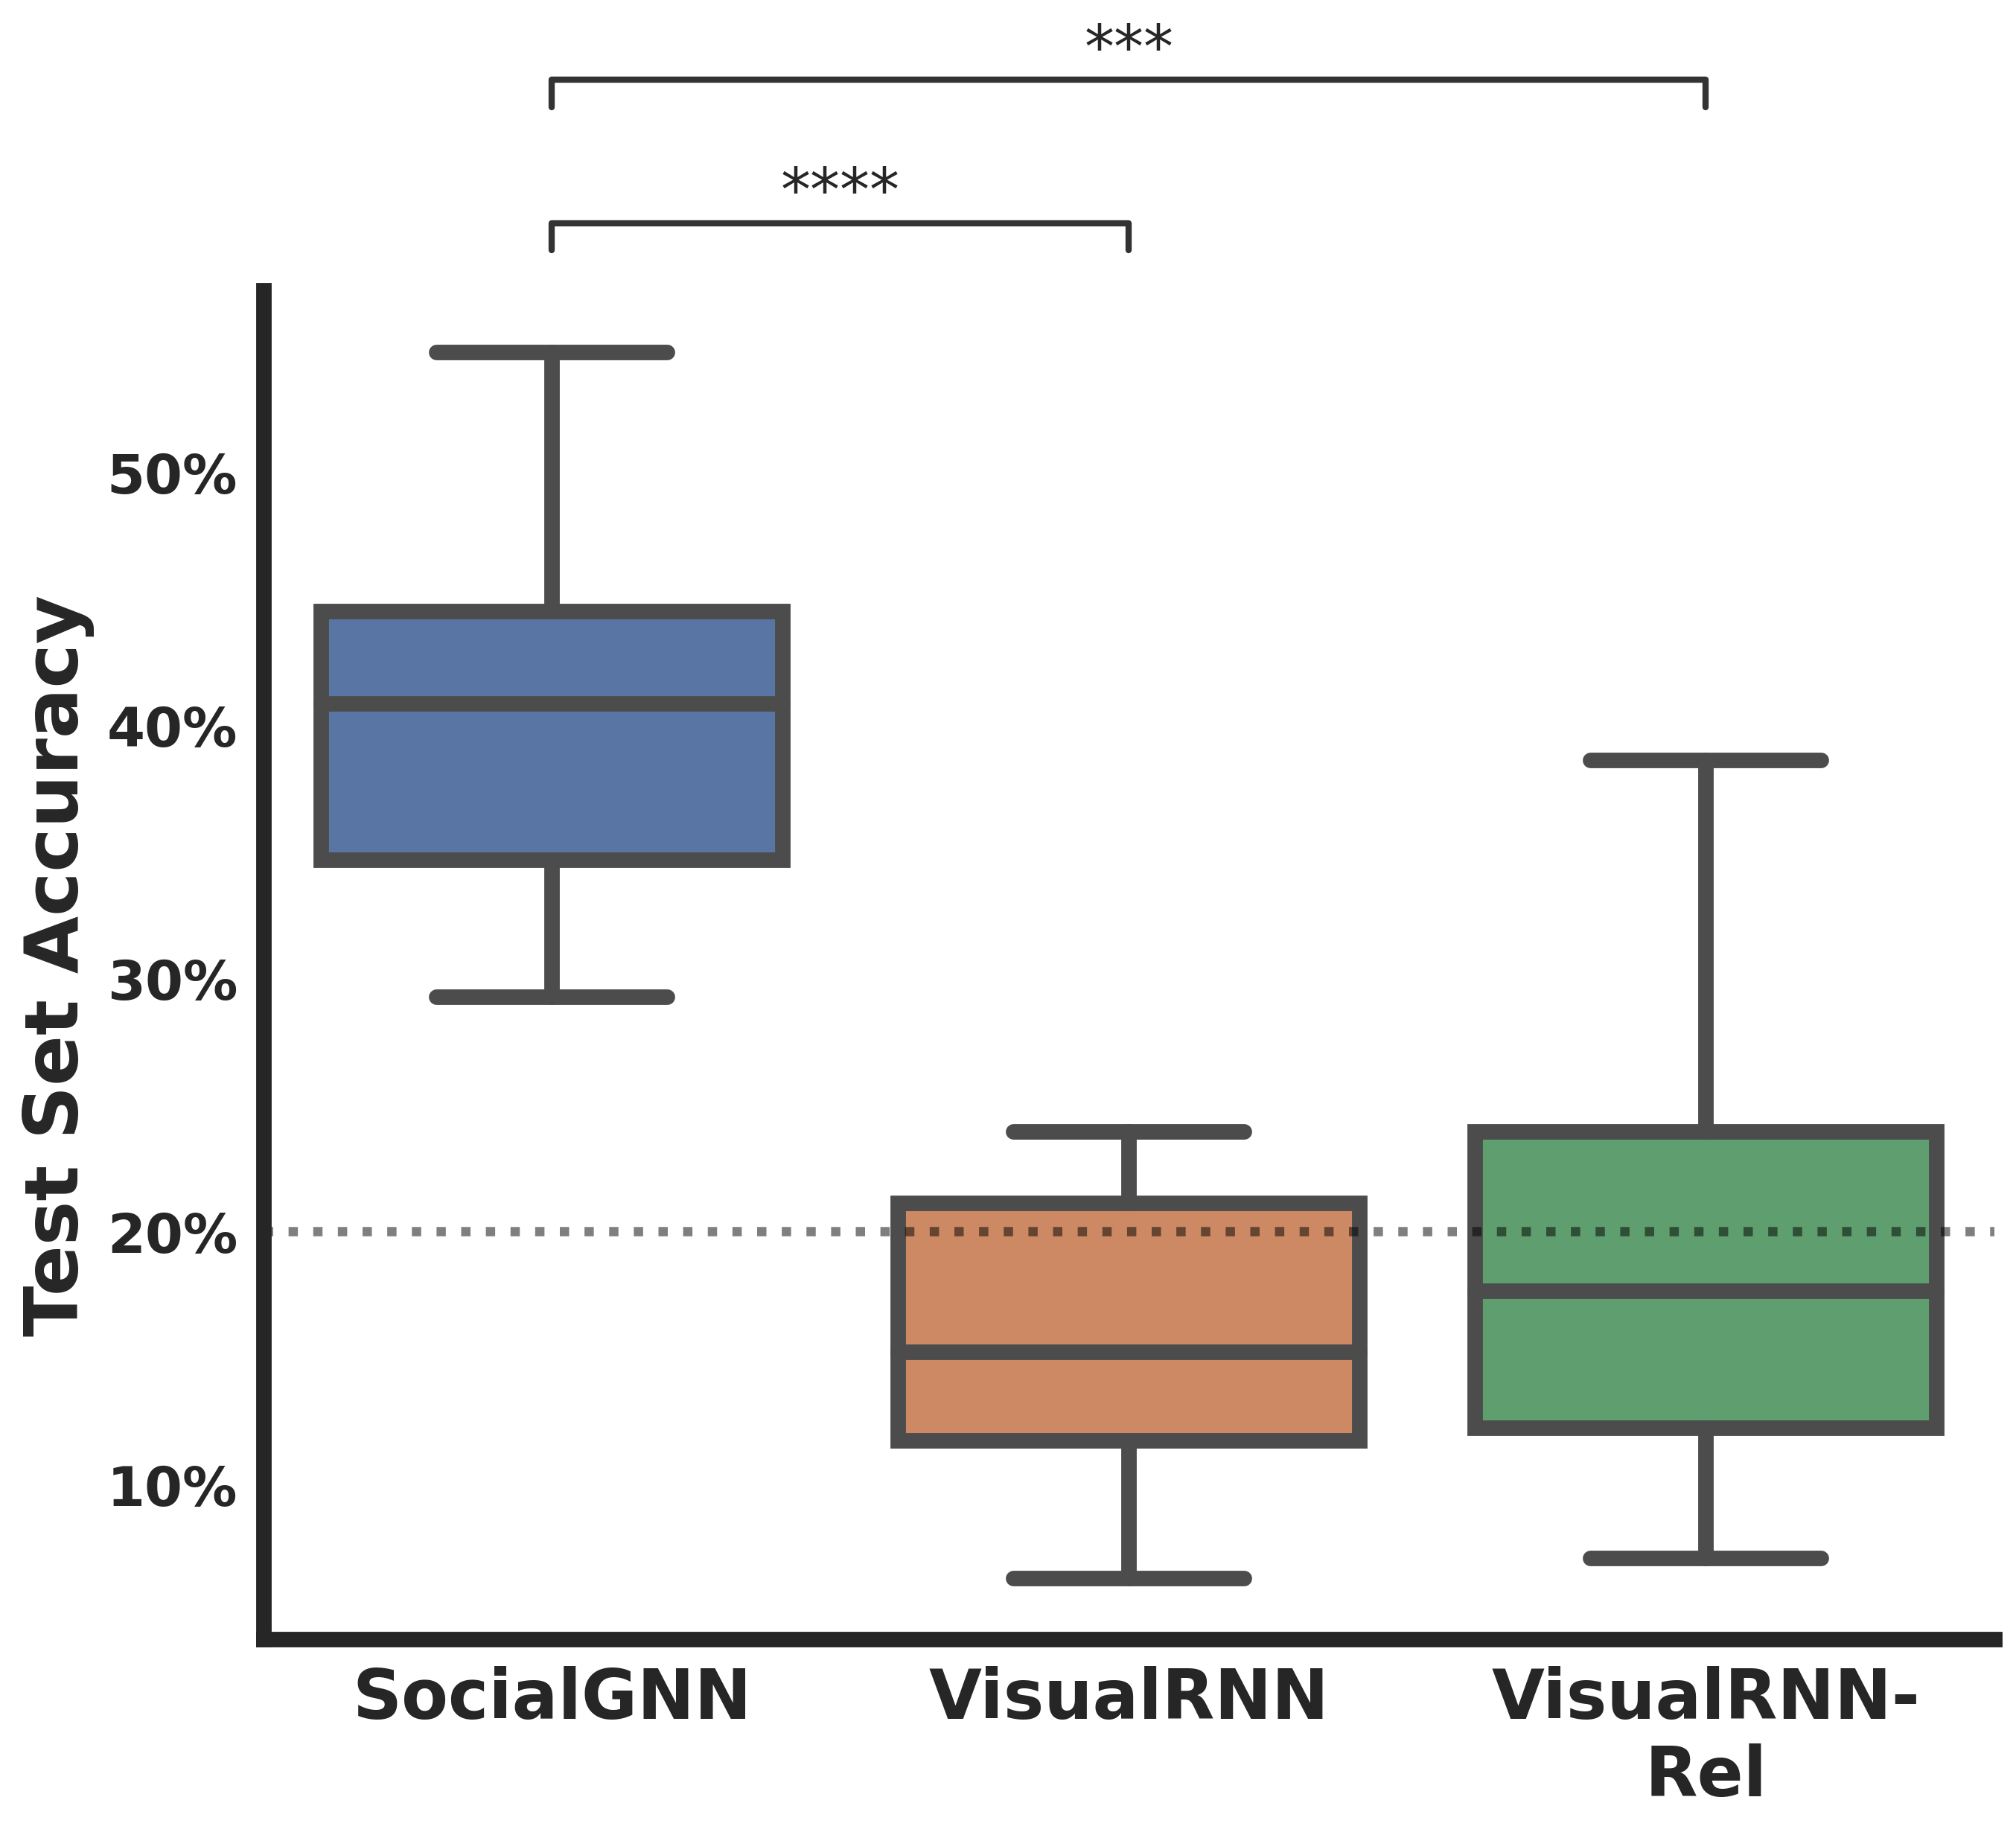

In [ ]:
from statannotations.Annotator import Annotator
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.concat([pd.DataFrame(SocialGNN_V), pd.DataFrame(CueBasedLSTM_6), pd.DataFrame(CueBasedLSTM_Relation_6)], keys=['SocialGNN','VisualRNN', 'VisualRNN-Rel']).reset_index()
del df['level_1']
df.rename(columns={'level_0': 'model', 'cross_val': 'cross_val_score', 'entire_trainset': 'trainset_accuracy', 'testset':'testset_accuracy'}, inplace=True)

f = sns.boxplot(x="model",y="testset_accuracy", data=df, linewidth = 5)
f.axhline(0.2, color = "black", ls = ":", alpha = 0.5, linewidth = 3) #alpha 0.8 for the poster

import textwrap
f.set_xticklabels(textwrap.fill(x.get_text(), 10) for x in f.get_xticklabels())
f.set_xticklabels(f.get_xticklabels(),rotation = 0, weight = "bold", fontsize=22)
f.set_yticklabels(f.get_xticklabels(),rotation = 0, weight = "bold")
f.set(xlabel=None)
plt.ylabel('Test Set Accuracy', weight="bold", fontsize=24)

# Significance testing
order = ['SocialGNN', 'VisualRNN', 'VisualRNN-Rel']
pairs=[("SocialGNN", "VisualRNN"), ("SocialGNN", "VisualRNN-Rel")]
annotator = Annotator(f, pairs, data=df, x="model", y="testset_accuracy", order=order)
annotator.configure(comparisons_correction="HB", test='t-test_paired', text_format='star', loc='outside', line_width = 2, line_offset=0.01, text_offset=0.01)
annotator.apply_and_annotate()

sns.despine() 
f.spines['left'].set_linewidth(5)
f.spines['bottom'].set_linewidth(5)

from matplotlib.ticker import FuncFormatter
f.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

from google.colab import files
plt.savefig("gaze_5.svg", bbox_inches = 'tight', transparent = False) #transparent=True for poster
#files.download("gaze_5.svg")

plt.show()